## Fifa Clustering to Help Club Managers

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import seaborn as sns # We will use this visualization library along with plotly later

In [2]:
# Read the data
fifa = pd.read_csv('fifa19.csv')
fifa = pd.DataFrame(fifa) # Putting it as a dataframe
fifa.head() # First few rows of the data

Unnamed: 0      ID               Name  Age  \
0           0  158023           L. Messi   31   
1           1   20801  Cristiano Ronaldo   33   
2           2  190871          Neymar Jr   26   
3           3  193080             De Gea   27   
4           4  192985       K. De Bruyne   27   

                                            Photo Nationality  \
0  https://cdn.sofifa.org/players/4/19/158023.png   Argentina   
1   https://cdn.sofifa.org/players/4/19/20801.png    Portugal   
2  https://cdn.sofifa.org/players/4/19/190871.png      Brazil   
3  https://cdn.sofifa.org/players/4/19/193080.png       Spain   
4  https://cdn.sofifa.org/players/4/19/192985.png     Belgium   

                                  Flag  Overall  Potential  \
0  https://cdn.sofifa.org/flags/52.png       94         94   
1  https://cdn.sofifa.org/flags/38.png       94         94   
2  https://cdn.sofifa.org/flags/54.png       92         93   
3  https://cdn.sofifa.org/flags/45.png       91         93   
4   https://cdn.sofifa.org/flags/7.png       91         92   

                  Club  ... Composure Marking StandingTackle  SlidingTackle  \
0         FC Barcelona  ...      96.0    33.0           28.0           26.0   
1             Juventus  ...      95.0    28.0           31.0           23.0   
2  Paris Saint-Germain  ...      94.0    27.0           24.0           33.0   
3    Manchester United  ...      68.0    15.0           21.0           13.0   
4      Manchester City  ...      88.0    68.0           58.0           51.0   

  GKDiving  GKHandling  GKKicking  GKPositioning GKReflexes Release Clause  
0      6.0        11.0       15.0           14.0        8.0        €226.5M  
1      7.0        11.0       15.0           14.0       11.0        €127.1M  
2      9.0         9.0       15.0           15.0       11.0        €228.1M  
3     90.0        85.0       87.0           88.0       94.0        €138.6M  
4     15.0        13.0        5.0           10.0       13.0        €196.4M  

[5 rows x 89 columns]

In [3]:
print("Total number of players in this dataset : ",fifa.shape[0]) # Total number of football players in this data

Total number of players in this dataset :  18207


## I. DATA CLEANING

We found many null values throughout the data and a few number of columns that were unwanted for our analysis. Following are the preprocessing steps we took for better analysis and good clustering:
    
1. Drop unwanted columns from the data.
    
2. Check for null values and remove them from each feature to get a clean data.
    
3. For the 'Club' column we didn't remove the null values but replaced them with 'Free Agent' as the that player currently has no club to play for.
    
4. We renamed the 'Contract Valid Until' column to 'Contract Valid Years' to get the total number of years left in the contract instead of manually calculating the total years left.

In [4]:
# Drop unwanted columns from the data
fifa.drop(columns=['Photo','Flag','Club Logo','Unnamed: 0','ID','Special','Body Type','Real Face',
                   'Loaned From','Jersey Number','Joined','Height', 'Weight'],inplace=True)

In [5]:
fifa.shape # We removed 13 features

(18207, 76)

In [6]:
fifa.isnull().sum() # Check for null values per column

Name                 0
Age                  0
Nationality          0
Overall              0
Potential            0
                  ... 
GKHandling          48
GKKicking           48
GKPositioning       48
GKReflexes          48
Release Clause    1564
Length: 76, dtype: int64

In [7]:
fifa['Club'].isnull()
fifa['Club'].replace(np.NaN,'Free Agent',inplace=True) # Replace NaN values in 'Club' with Free Agent

In [8]:
fifa.dropna(subset=['Position'],axis=0,inplace=True) # Drop NaN values for all positions 
fifa.reset_index(drop=True,inplace=True)

In [9]:
fifa.isnull().sum() # Verify if null values were removed properly till now

Name                 0
Age                  0
Nationality          0
Overall              0
Potential            0
                  ... 
GKHandling           0
GKKicking            0
GKPositioning        0
GKReflexes           0
Release Clause    1504
Length: 76, dtype: int64

In [10]:
fifa['Contract Valid Until']=fifa['Contract Valid Until'].str.split(pat=',').str[-1]
fifa['Contract Valid Until']=fifa['Contract Valid Until'].str.strip(' ')
fifa['Contract Valid Until'].fillna('2018',inplace=True) # Include 2018 year in this column
fifa['Contract Valid Until'].unique()

array(['2021', '2022', '2020', '2023', '2019', '2024', '2025', '2026',
       '2018'], dtype=object)

In [11]:
fifa.rename(columns={'Contract Valid Until':'Contract Valid Years'},inplace=True) # Rename the column
fifa['Contract Valid Years']=fifa['Contract Valid Years'].astype('int')
fifa['Contract Valid Years']=fifa['Contract Valid Years'] - 2018 # (Current year - 2018) to get total number of years.
fifa['Contract Valid Years']

0        3
1        4
2        4
3        2
4        5
        ..
18142    1
18143    2
18144    3
18145    1
18146    1
Name: Contract Valid Years, Length: 18147, dtype: int64

In [12]:
fifa['Release Clause'].fillna('0',inplace=True)

In [13]:
fifa.isnull().sum() # We have removed all null values now

Name              0
Age               0
Nationality       0
Overall           0
Potential         0
                 ..
GKHandling        0
GKKicking         0
GKPositioning     0
GKReflexes        0
Release Clause    0
Length: 76, dtype: int64

We converted the columns 'Value','Wage' and 'Release Clause' to float values after removing the currency symbol and the suffix so that we can generate the values easily and get a better idea of those values.

In [14]:
# Check data type for these features
print(fifa['Value'].dtypes)
print(fifa['Wage'].dtypes)
print(fifa['Release Clause'].dtypes)

object
object
object


In [15]:
# Remove currency symbol and suffix and convert them into float values later
fifa['Value']=fifa['Value'].str.strip('€')
fifa['Wage']=fifa['Wage'].str.strip('€')
fifa['Release Clause']=fifa['Release Clause'].str.strip('€')

for i in np.arange(fifa.shape[0]):
    if fifa['Value'][i][-1] == 'M':
        fifa['Value'][i]= float(fifa['Value'][i].rstrip('M')) * 1000000
        
    elif fifa['Value'][i][-1] =='K':
          fifa['Value'][i]= float(fifa['Value'][i].rstrip('K')) * 1000
        
    else:
        fifa['Value'][i]= float(fifa['Value'][i])
        
        
        
    if fifa['Wage'][i][-1] =='K':
        fifa['Wage'][i]= float(fifa['Wage'][i].rstrip('K')) * 1000
        
    else:
        fifa['Wage'][i]= float(fifa['Wage'][i]) 
        
        
        
    if fifa['Release Clause'][i][-1] == 'M':
         fifa['Release Clause'][i]= float(fifa['Release Clause'][i].rstrip('M')) * 1000000
        
    elif fifa['Release Clause'][i][-1] =='K':
          fifa['Release Clause'][i]= float(fifa['Release Clause'][i].rstrip('K')) * 1000
        
    else:
        fifa['Release Clause'][i]= float(fifa['Release Clause'][i])     

<ipython-input-15-6e43706d0940>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fifa['Value'][i]= float(fifa['Value'][i].rstrip('M')) * 1000000
<ipython-input-15-6e43706d0940>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fifa['Wage'][i]= float(fifa['Wage'][i].rstrip('K')) * 1000
<ipython-input-15-6e43706d0940>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fifa['Release Clause'][i]= float(fifa['Release Clause'][i].rstrip('M'))

In [16]:
# Converting all values to float
fifa['Value']=fifa['Value'].astype('float')
fifa['Wage']=fifa['Wage'].astype('float')
fifa['Release Clause']=fifa['Release Clause'].astype('float')

In [17]:
fifa.head() # Final cleaned dataset

Name  Age Nationality  Overall  Potential  \
0           L. Messi   31   Argentina       94         94   
1  Cristiano Ronaldo   33    Portugal       94         94   
2          Neymar Jr   26      Brazil       92         93   
3             De Gea   27       Spain       91         93   
4       K. De Bruyne   27     Belgium       91         92   

                  Club        Value      Wage Preferred Foot  \
0         FC Barcelona  110500000.0  565000.0           Left   
1             Juventus   77000000.0  405000.0          Right   
2  Paris Saint-Germain  118500000.0  290000.0          Right   
3    Manchester United   72000000.0  260000.0          Right   
4      Manchester City  102000000.0  355000.0          Right   

   International Reputation  ...  Composure  Marking StandingTackle  \
0                       5.0  ...       96.0     33.0           28.0   
1                       5.0  ...       95.0     28.0           31.0   
2                       5.0  ...       94.0     27.0           24.0   
3                       4.0  ...       68.0     15.0           21.0   
4                       4.0  ...       88.0     68.0           58.0   

  SlidingTackle  GKDiving GKHandling GKKicking GKPositioning GKReflexes  \
0          26.0       6.0       11.0      15.0          14.0        8.0   
1          23.0       7.0       11.0      15.0          14.0       11.0   
2          33.0       9.0        9.0      15.0          15.0       11.0   
3          13.0      90.0       85.0      87.0          88.0       94.0   
4          51.0      15.0       13.0       5.0          10.0       13.0   

  Release Clause  
0    226500000.0  
1    127100000.0  
2    228100000.0  
3    138600000.0  
4    196400000.0  

[5 rows x 76 columns]

## II. DATA ANALYSIS

We analyzed few features along with some visualizations to give a manager the basic idea of all players present in the dataset so that the manager can filter or search for a particular need or quality from a player. We have also tried to give a generalised analysis for the data from which the managers can get their strategic minds to work. There are in total about 652 clubs across the whole world which we will analayze and cluster.

In [18]:
# Total number of football clubs around the world 
print('Total number of clubs : {0}'.format(fifa['Club'].nunique()))

Total number of clubs : 652


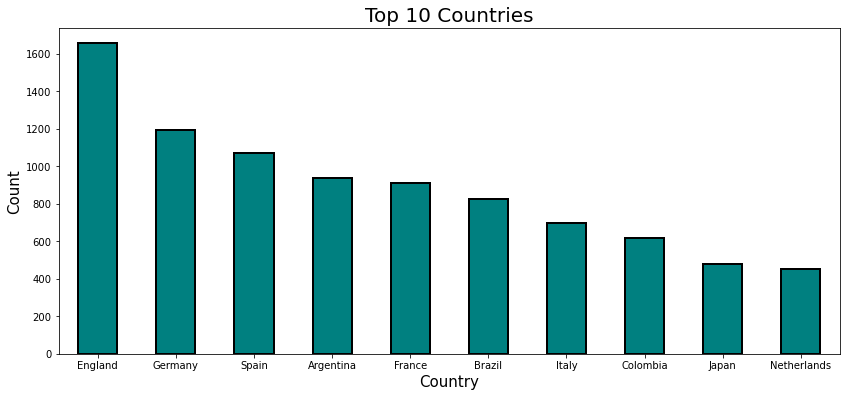

In [19]:
# Total player counts from top 10 countries
plt.figure(figsize=(14,6))
fifa["Nationality"].value_counts()[:10].plot(kind="bar",color="teal",lw=2,edgecolor="black")
plt.xticks(rotation=0)
plt.xlabel("Country",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.title("Top 10 Countries",fontsize=20)
plt.show()

Clearly most football players are from England with a count of 1657 followed by Germany having 1195 players. This makes sense because countries like England, Germany, Spain and South America are football nations that have greatly inspired other countries to follow football.

In [20]:
# Count of players for each position
print("Total count of Players for each position")
print("----------------------------------------")
pd.DataFrame(fifa.Position.value_counts())

Total count of Players for each position
----------------------------------------


Position
ST       2152
GK       2025
CB       1778
CM       1394
LB       1322
RB       1291
RM       1124
LM       1095
CAM       958
CDM       948
RCB       662
LCB       648
LCM       395
RCM       391
LW        381
RW        370
RDM       248
LDM       243
LS        207
RS        203
RWB        87
LWB        78
CF         74
LAM        21
RAM        21
RF         16
LF         15

There are in total 27 different positions that players play in during a match and we can see a count of total players from every position. This may not be that important since it depends on the manager where he wants his player to play and how he wants his player to play. It depends on the manager what formation he would prefer strategically to play a match. Here the manager can still use this table to get an idea about the specific positioned player he wishes to have in his team.

A player can have a preferred foot or a strong foot. This can be impactful for a manager to determine the chemistry of that player with other team mates. This is because 'crossing', 'passing', 'shoot' of a player will be effective if paired with a proper player position and strong/preferred foot. According to the plot, right foot is majorly preferred by players albeit striker or goalkeeper etc.

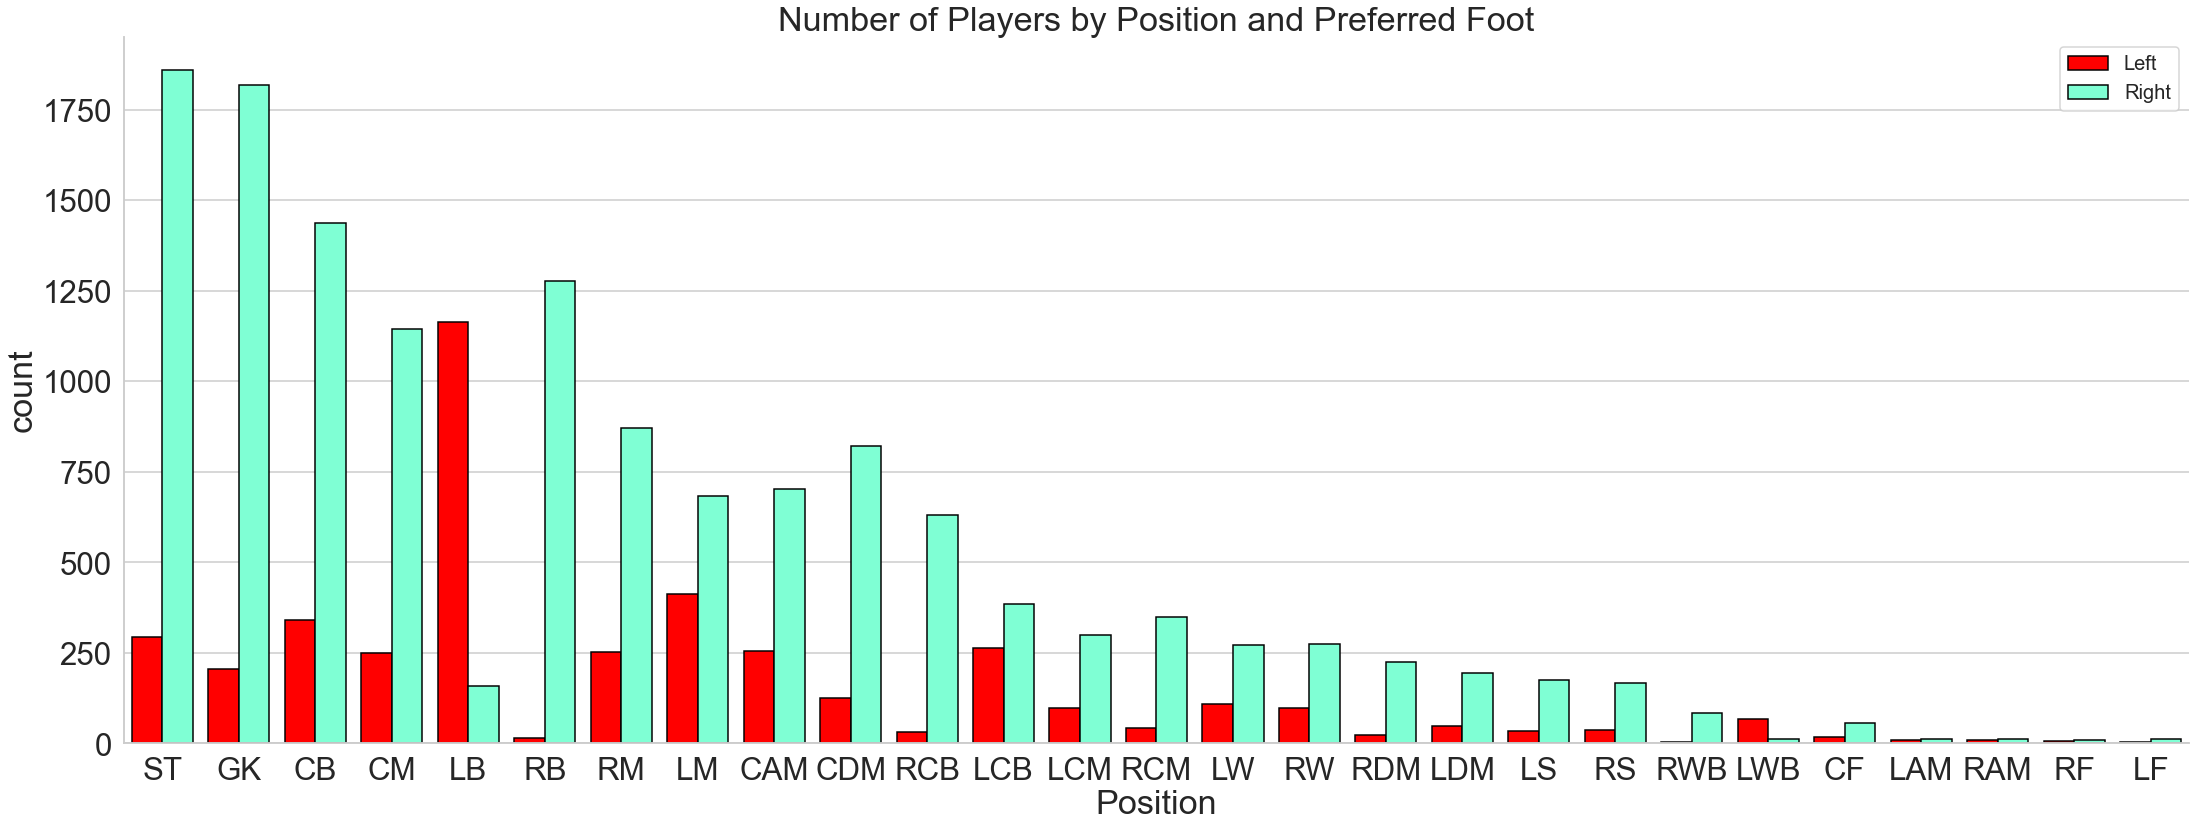

In [21]:
# Total number of right-footed and left-footed players playing in each position
sns.set_style('whitegrid', {'patch.edgecolor': 'black'})
sns.set_context('talk', font_scale=1.9)
plt.figure(figsize=(37,13))
pos_count = sns.countplot(data=fifa, x='Position', hue='Preferred Foot', order=fifa['Position'].value_counts().index, 
                          palette={'Left':'red', 'Right':'aquamarine'}, saturation=1)
plt.legend(markerscale=2, fontsize=20)
pos_count.set_title('Number of Players by Position and Preferred Foot')
sns.despine(top=True, right=True)

Players' name and their positions were then appended in an empty list named 'full_name'. This can prove helpful for managers to deduce which player performs the best in a specific position along with the player's overall rating.

In [22]:
# Get the best player for each position
full_name = [] 
best_name=''
pos = ''


for pos in fifa.Position.unique()[:-1]:

    best_overall = fifa[fifa.Position == pos].Overall.max()
    best_name = fifa[(fifa['Position']== pos) & (fifa['Overall'] == best_overall) ].Name.iloc[0]
    full_name.append({'Position':pos,
                        'Name':best_name,
                        'Overall':best_overall})
    
    
    
best_player = pd.DataFrame(full_name)
best_player

Position               Name  Overall
0        RF           L. Messi       94
1        ST  Cristiano Ronaldo       94
2        LW          Neymar Jr       92
3        GK             De Gea       91
4       RCM       K. De Bruyne       91
5        LF          E. Hazard       91
6        RS          L. Suárez       91
7       RCB       Sergio Ramos       91
8       LCM           T. Kroos       90
9        CB           D. Godín       90
10      LDM           N. Kanté       89
11      CAM       A. Griezmann       89
12      CDM    Sergio Busquets       89
13       LS          E. Cavani       89
14      LCB       G. Chiellini       89
15       RM          K. Mbappé       88
16      LAM       J. Rodríguez       88
17       LM      P. Aubameyang       88
18       LB            Marcelo       88
19      RDM           P. Pogba       87
20       RW     Bernardo Silva       86
21       CM             Thiago       86
22       RB        Azpilicueta       86
23      RAM        J. Cuadrado       84
24       CF       Luis Alberto       82
25      RWB          M. Ginter       80

Finding a clubs average overall rating of the players in the squad helps managers managing small teams big time as they always look to loan players from big teams where many good players don't get a chance to play regularly. So this proves really beneficial for small club managers to loan good players from all top teams.

In [23]:
# Top clubs with best average overall rating
print("Top 10 Clubs of Average Overall...")
pd.DataFrame(fifa.groupby("Club")["Overall"].mean().sort_values(ascending=False)[:10])

Top 10 Clubs of Average Overall...


Overall
Club                          
Juventus             82.280000
Napoli               80.000000
Inter                79.750000
Real Madrid          78.242424
Milan                78.074074
FC Barcelona         78.030303
Paris Saint-Germain  77.433333
Roma                 77.423077
Manchester United    77.242424
SL Benfica           77.000000

In [24]:
# Top valuable clubs across the world
pd.DataFrame(fifa.groupby("Club")["Value"].sum().sort_values(ascending=False)[:10])

Value
Club                            
Real Madrid          874425000.0
FC Barcelona         852600000.0
Manchester City      786555000.0
Juventus             704475000.0
FC Bayern München    679025000.0
Atlético Madrid      644525000.0
Paris Saint-Germain  625325000.0
Tottenham Hotspur    618450000.0
Chelsea              606815000.0
Manchester United    588850000.0

This dataframe just gives an idea about the biggest teams in world football in terms of their value. We can see that Real Madrid and Barcelona are most valuable clubs around the world even though both clubs belong to the same country, i.e. Spain.

Suppose a transfer were to happen between two teams, managers of respective teams can evaluate their requirements according to average and overall team valuation. Once that is decided, the following code will help deduce to narrow down players according to player ratings and get the top player for every different attribute(i.e. best crosser or best finisher).

In [25]:
# Best player for each attribute
pr_cols=['Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys',
       'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
       'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance',
       'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
       'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
       'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes']
print('BEST IN DIFFERENT ASPECTS :')
print('_________________________\n\n')
i=0
while i < len(pr_cols):
    print('Best {0} : {1}'.format(pr_cols[i],fifa.loc[fifa[pr_cols[i]].idxmax()][0]))
    i += 1

BEST IN DIFFERENT ASPECTS :
_________________________


Best Crossing : K. De Bruyne
Best Finishing : L. Messi
Best HeadingAccuracy : Naldo
Best ShortPassing : L. Modrić
Best Volleys : E. Cavani
Best Dribbling : L. Messi
Best Curve : Quaresma
Best FKAccuracy : L. Messi
Best LongPassing : T. Kroos
Best BallControl : L. Messi
Best Acceleration : Douglas Costa
Best SprintSpeed : K. Mbappé
Best Agility : Neymar Jr
Best Reactions : Cristiano Ronaldo
Best Balance : Bernard
Best ShotPower : Cristiano Ronaldo
Best Jumping : Cristiano Ronaldo
Best Stamina : N. Kanté
Best Strength : A. Akinfenwa
Best LongShots : L. Messi
Best Aggression : B. Pearson
Best Interceptions : N. Kanté
Best Positioning : Cristiano Ronaldo
Best Vision : L. Messi
Best Penalties : M. Balotelli
Best Composure : L. Messi
Best Marking : A. Barzagli
Best StandingTackle : G. Chiellini
Best SlidingTackle : Sergio Ramos
Best GKDiving : De Gea
Best GKHandling : J. Oblak
Best GKKicking : M. Neuer
Best GKPositioning : G. Buffon
Bes

Giving the slightest idea about a list of potential players from around the world helps a manager to scout a particular player from the list for future signings.

In [26]:
# Top 20 potential players for future
fifa.sort_values("Potential", ascending=False)[['Name', "Age", "Value", "Overall", 'Potential']].head(20)

Name  Age        Value  Overall  Potential
25            K. Mbappé   19   81000000.0       88         95
0              L. Messi   31  110500000.0       94         94
15            P. Dybala   24   89000000.0       89         94
1     Cristiano Ronaldo   33   77000000.0       94         94
2             Neymar Jr   26  118500000.0       92         93
3                De Gea   27   72000000.0       91         93
9              J. Oblak   25   68000000.0       90         93
229       G. Donnarumma   19   29000000.0       82         93
79        Marco Asensio   22   54000000.0       85         92
1143    Vinícius Júnior   17   17500000.0       77         92
55              L. Sané   22   61000000.0       86         92
42            S. Umtiti   24   57000000.0       87         92
155          O. Dembélé   21   40000000.0       83         92
156       Gabriel Jesus   21   41000000.0       83         92
18        M. ter Stegen   26   58000000.0       89         92
77          M. Škriniar   23   46500000.0       85         92
4          K. De Bruyne   27  102000000.0       91         92
16              H. Kane   24   83500000.0       89         91
30                 Isco   26   73500000.0       88         91
5             E. Hazard   27   93000000.0       91         91

The plot below depicts the relationship between player age and their 'Potential' and 'Overall Rating'. In the age group of 28-30, 'overall' and 'Potential' lines converge determining that best chance of meeting requirements of a manager can be found majorly in this group. At young age range, 'potential' of a player is very high but 'overall rating' is compromised. This is affected because the player (of young age group) can have lesser number of matches played, lesser exposure and less records.

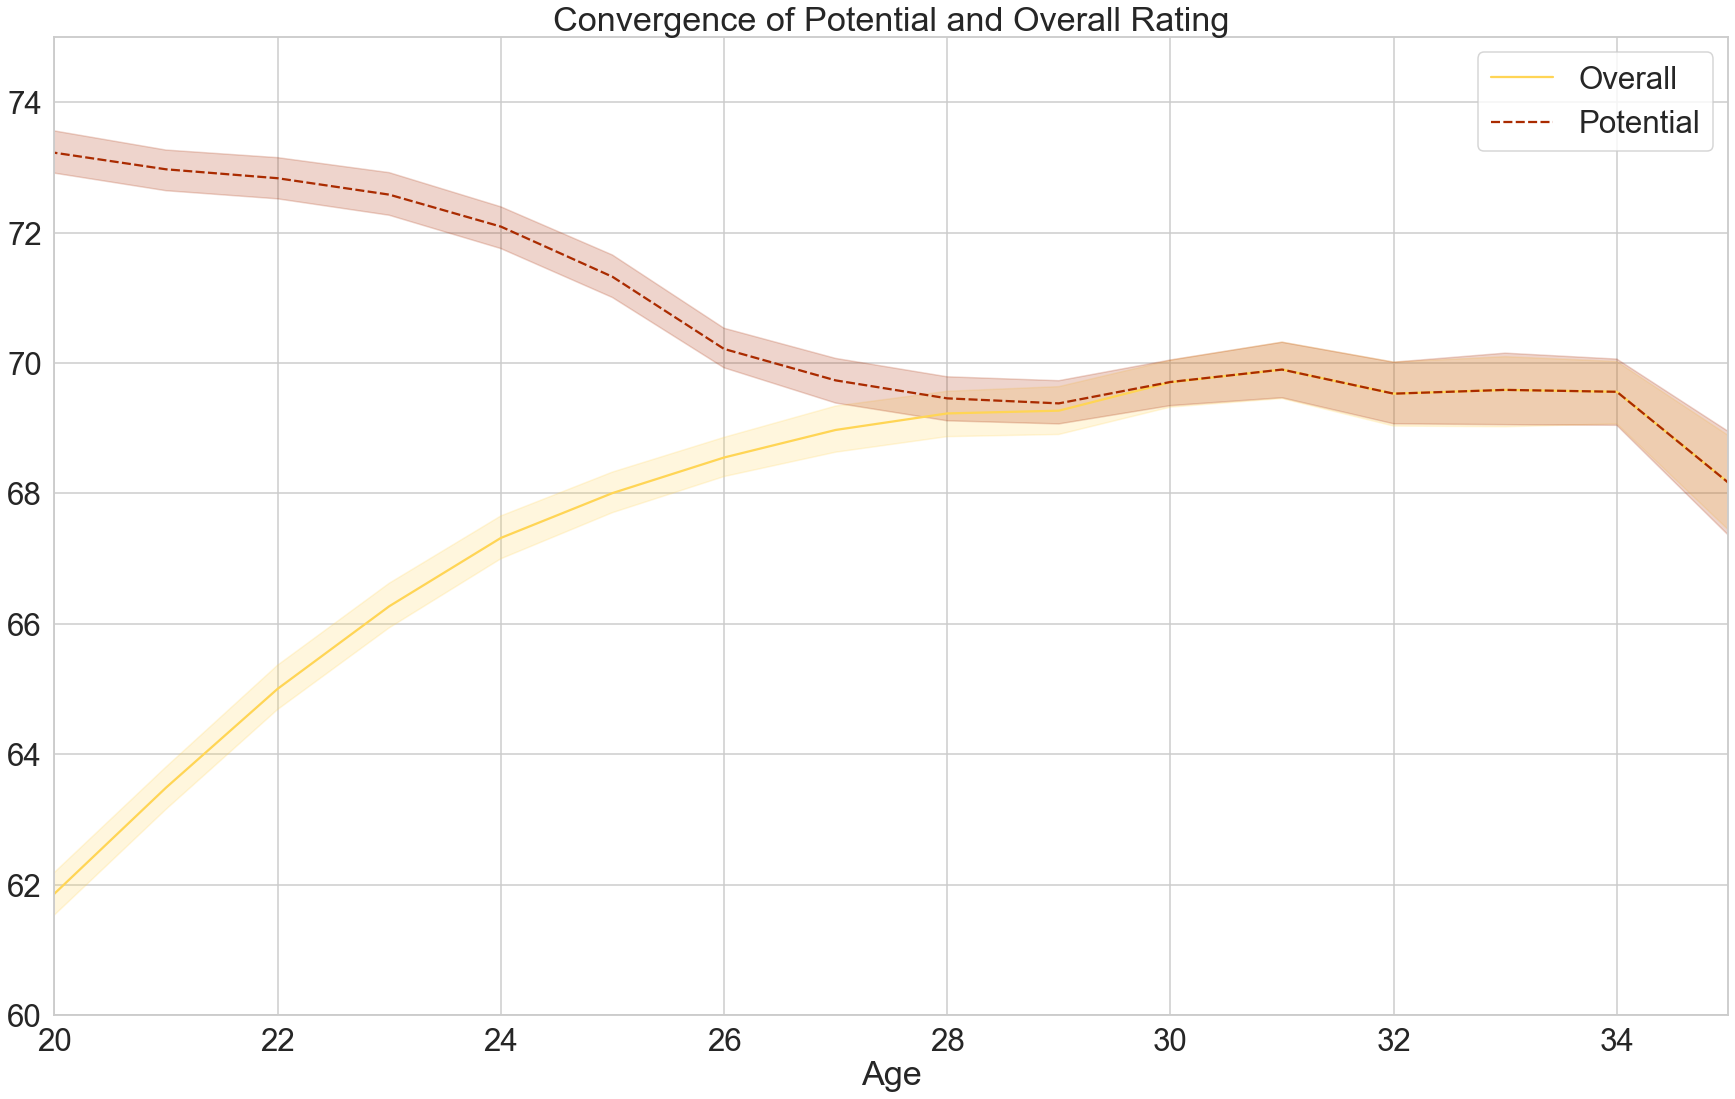

In [27]:
# Age range to find the best potential in a player
ovl_pot_df = pd.concat([fifa['Overall'], fifa['Potential']], axis=1)
ovl_pot_df.index = fifa['Age']
sns.set_style('whitegrid', {'figure.facecolor':'white', 'axes.facecolor': 'white'})
plt.figure(figsize=(30,18))
ax = plt.gca(xlim=(20,35), ylim=(60,75)) # for setting the axes limits
regplt = sns.lineplot(data=ovl_pot_df, ax=ax, palette='afmhot_r')
regplt.set_title('Convergence of Potential and Overall Rating')
plt.show()

Higher the rating of a player, higher will be their valuation. Majority of the players fall in the '70-85' ratings making the average valuation of the players to be between 20 and 40 million.

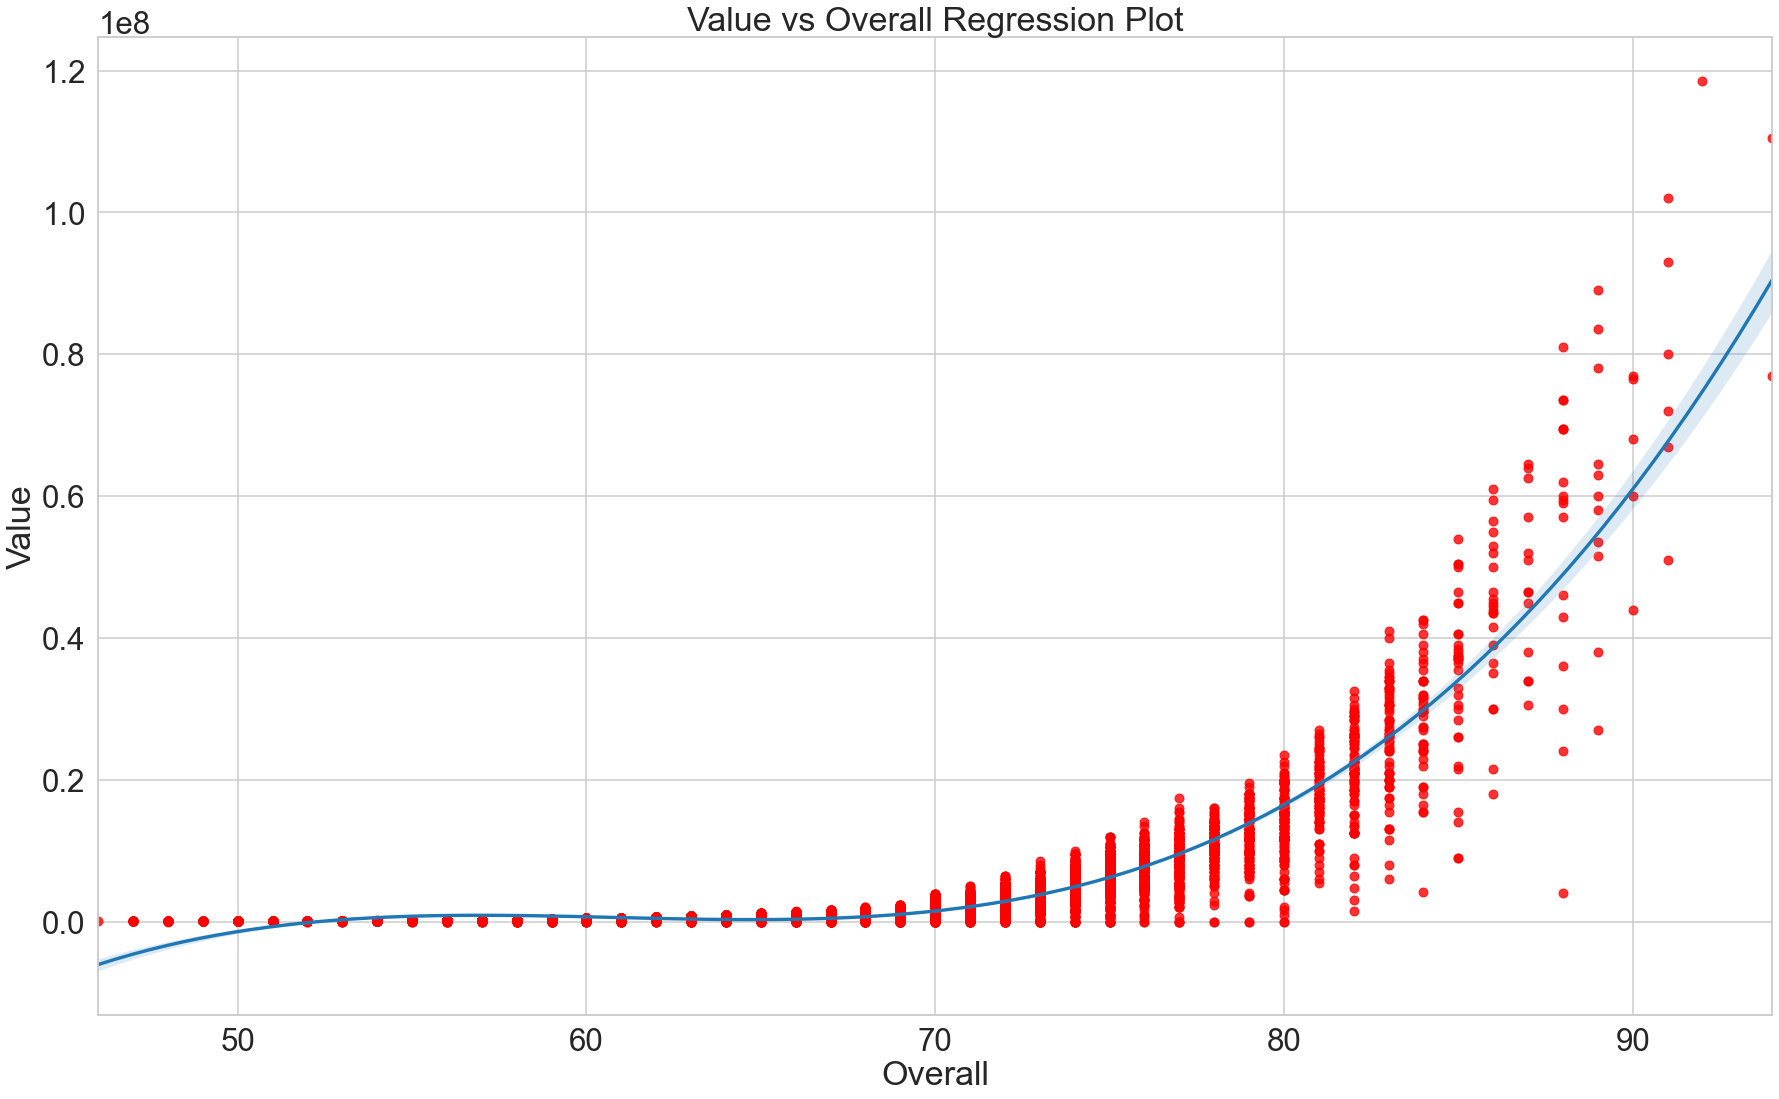

In [28]:
# Understand the relationship between Value and the Overall rating
plt.figure(figsize=(30,18))
reg_plot = sns.regplot(data=fifa, x='Overall', y='Value', order=3, scatter_kws={'s':80, 'color':(1,0,0)})
reg_plot.set_title('Value vs Overall Regression Plot')
plt.show()

The following graph can be analyzed considering player positions and features. Suppose, players in 'striker' position has better 'acceleration, 'Finishing' and 'Balance'. Different positions have different attributes in which they can be compatible. A goalkeeper might not be good in 'Finishing' and 'acceleration' but his attributes will be evaluted in ''GKDiving','GKHandling','GKKicking','GKPositioning','GKReflexes'.

<ipython-input-29-b69cab9c044c>:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  for position_name, features in fifa.groupby(fifa['Position'])[player_features].mean().iterrows():


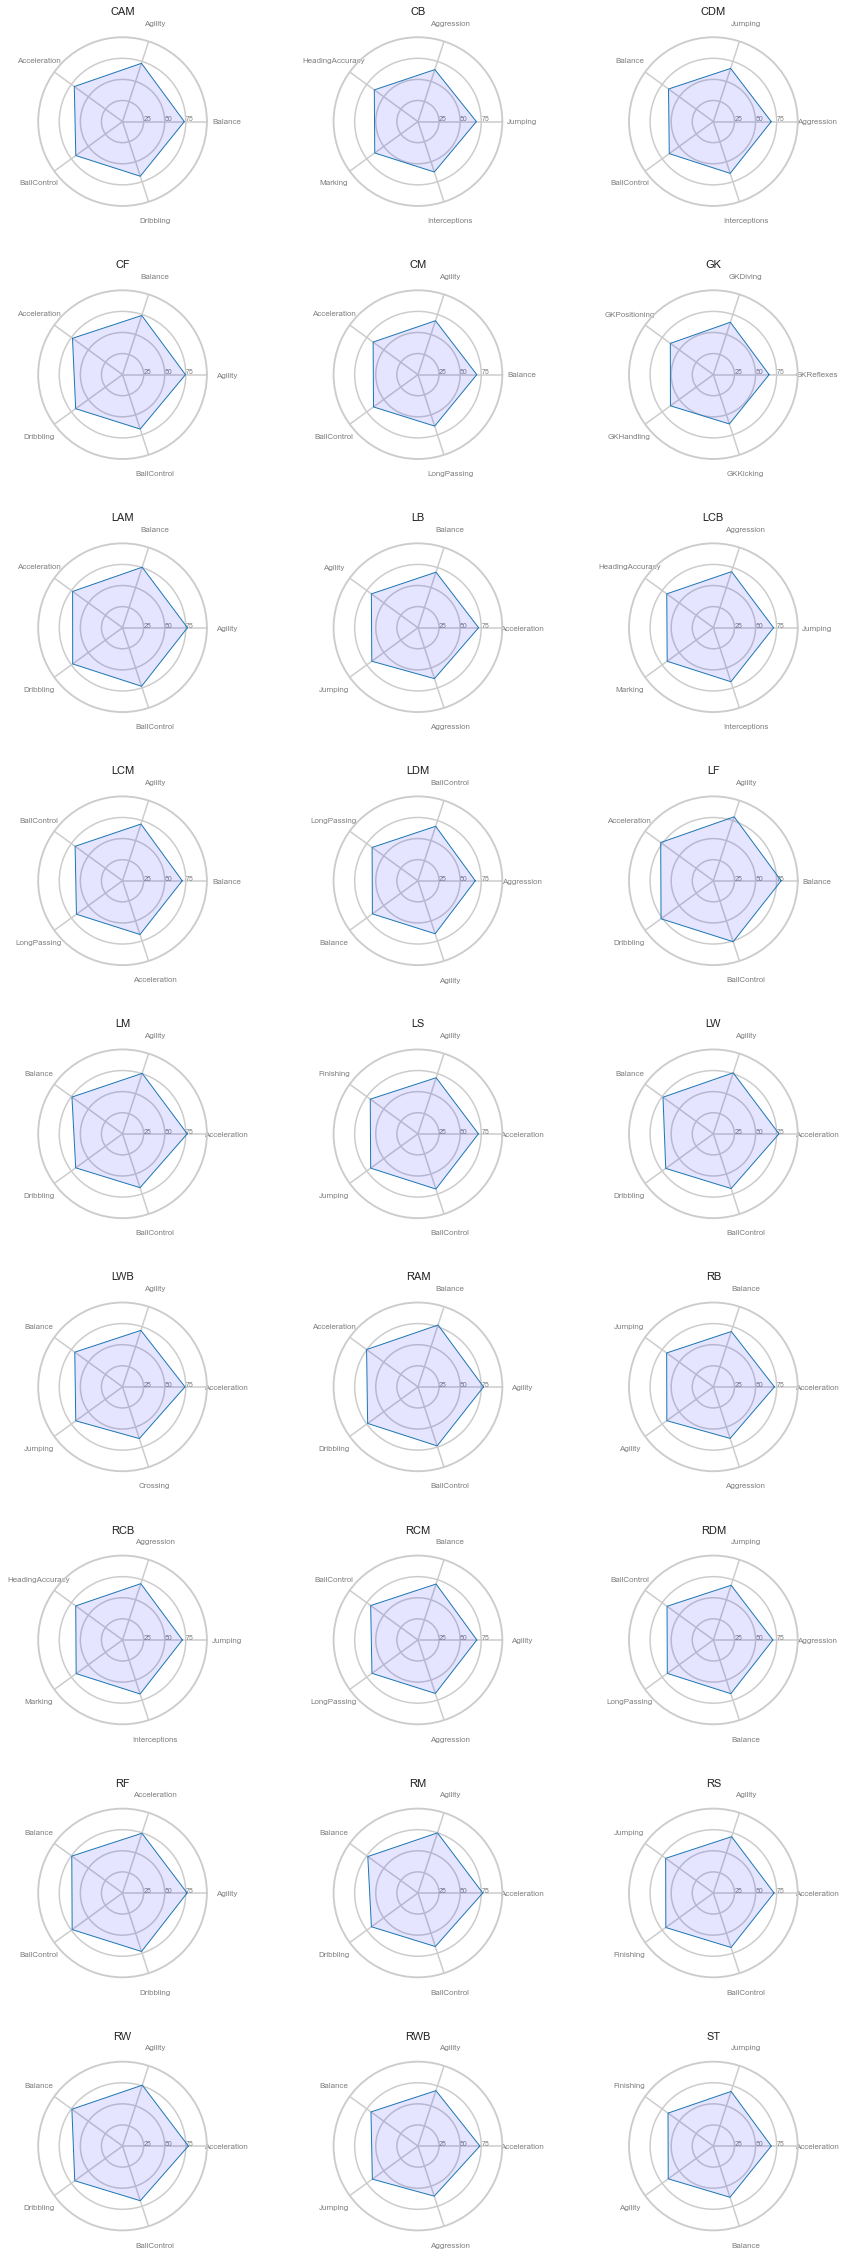

In [29]:
player_features = (
    'Acceleration', 'Aggression', 'Agility', 
    'Balance', 'BallControl', 'Composure', 
    'Crossing', 'Dribbling', 'FKAccuracy', 
    'Finishing', 'GKDiving', 'GKHandling', 
    'GKKicking', 'GKPositioning', 'GKReflexes', 
    'HeadingAccuracy', 'Interceptions', 'Jumping', 
    'LongPassing', 'LongShots', 'Marking', 'Penalties'
)

from math import pi
idx = 1
plt.figure(figsize=(15,45))
for position_name, features in fifa.groupby(fifa['Position'])[player_features].mean().iterrows():
    top_features = dict(features.nlargest(5))
    
    # number of variable
    categories=top_features.keys()
    N = len(categories)
    
    values = list(top_features.values())
    values += values[:1]
    
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    ax = plt.subplot(10, 3, idx, polar=True)

    plt.xticks(angles[:-1], categories, color='grey', size=8)
    
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([25,50,75], ["25","50","75"], color="grey", size=7)
    plt.ylim(0,100)
    
    plt.subplots_adjust(hspace = 0.5)
    
    # Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid')

    # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)
    
    plt.title(position_name, size=11, y=1.1)
    
    idx += 1

Now we have grouped all positions into 4 main categories of players for further analysis including clustering so that the manager can easily figure out what category of players he wishes to think of having in his team.

In [30]:
# Grouping different positions to 4 main groups
DEFENDING = ["CB","LB","LCB","LWB","RB","RCB","RWB"]
MIDFIELD = ["CAM","CDM","CM","LAM","LCM","LDM","LM","RAM","RCM","RDM","RM"]
ATTACKING = ["CF","LF","RF","RS","RW","LW","LS","ST"]
GOALKEEPER = ["GK"]

position = []

for i in fifa["Position"]:
    if i in DEFENDING:
        position.append("Defending")
    elif i in MIDFIELD:
        position.append("Midfield")
    elif i in ATTACKING:
        position.append("Attacking")
    elif i in GOALKEEPER:
        position.append("Goalkeeper")
    else:
        position.append(np.nan)
fifa["Main Position"] = position # Gets added to the data as a new column

We want only good players know for which we have filtered and removed players having overall ratings below 83.

In [31]:
# Get players with ratings above 83 only
fifa = fifa[fifa.Overall > 83]
fifa.shape

(155, 77)

In [32]:
# Create a new dataframe for further analysis of players
attributes = fifa.iloc[:,41:89]
attributes.drop("Release Clause",axis=1,inplace=True)
attributes["Name"]=fifa["Name"]
attributes = attributes.set_index("Name")
attributes.dropna(inplace=True)
attributes.head()

Crossing  Finishing  HeadingAccuracy  ShortPassing  \
Name                                                                    
L. Messi               84.0       95.0             70.0          90.0   
Cristiano Ronaldo      84.0       94.0             89.0          81.0   
Neymar Jr              79.0       87.0             62.0          84.0   
De Gea                 17.0       13.0             21.0          50.0   
K. De Bruyne           93.0       82.0             55.0          92.0   

                   Volleys  Dribbling  Curve  FKAccuracy  LongPassing  \
Name                                                                    
L. Messi              86.0       97.0   93.0        94.0         87.0   
Cristiano Ronaldo     87.0       88.0   81.0        76.0         77.0   
Neymar Jr             84.0       96.0   88.0        87.0         78.0   
De Gea                13.0       18.0   21.0        19.0         51.0   
K. De Bruyne          82.0       86.0   85.0        83.0         91.0   

                   BallControl  ...  Composure  Marking  StandingTackle  \
Name                            ...                                       
L. Messi                  96.0  ...       96.0     33.0            28.0   
Cristiano Ronaldo         94.0  ...       95.0     28.0            31.0   
Neymar Jr                 95.0  ...       94.0     27.0            24.0   
De Gea                    42.0  ...       68.0     15.0            21.0   
K. De Bruyne              91.0  ...       88.0     68.0            58.0   

                   SlidingTackle  GKDiving  GKHandling  GKKicking  \
Name                                                                
L. Messi                    26.0       6.0        11.0       15.0   
Cristiano Ronaldo           23.0       7.0        11.0       15.0   
Neymar Jr                   33.0       9.0         9.0       15.0   
De Gea                      13.0      90.0        85.0       87.0   
K. De Bruyne                51.0      15.0        13.0        5.0   

                   GKPositioning  GKReflexes  Main Position  
Name                                                         
L. Messi                    14.0         8.0      Attacking  
Cristiano Ronaldo           14.0        11.0      Attacking  
Neymar Jr                   15.0        11.0      Attacking  
De Gea                      88.0        94.0     Goalkeeper  
K. De Bruyne                10.0        13.0       Midfield  

[5 rows x 35 columns]

It will be easy for a manager to pick his choice of player when he gets to see a list of players with all attribute values for comparison. This is done for each of the 4 categories. This way the manager can choose a category or even filter it by a specific team and then see the Heatmap for each category. 

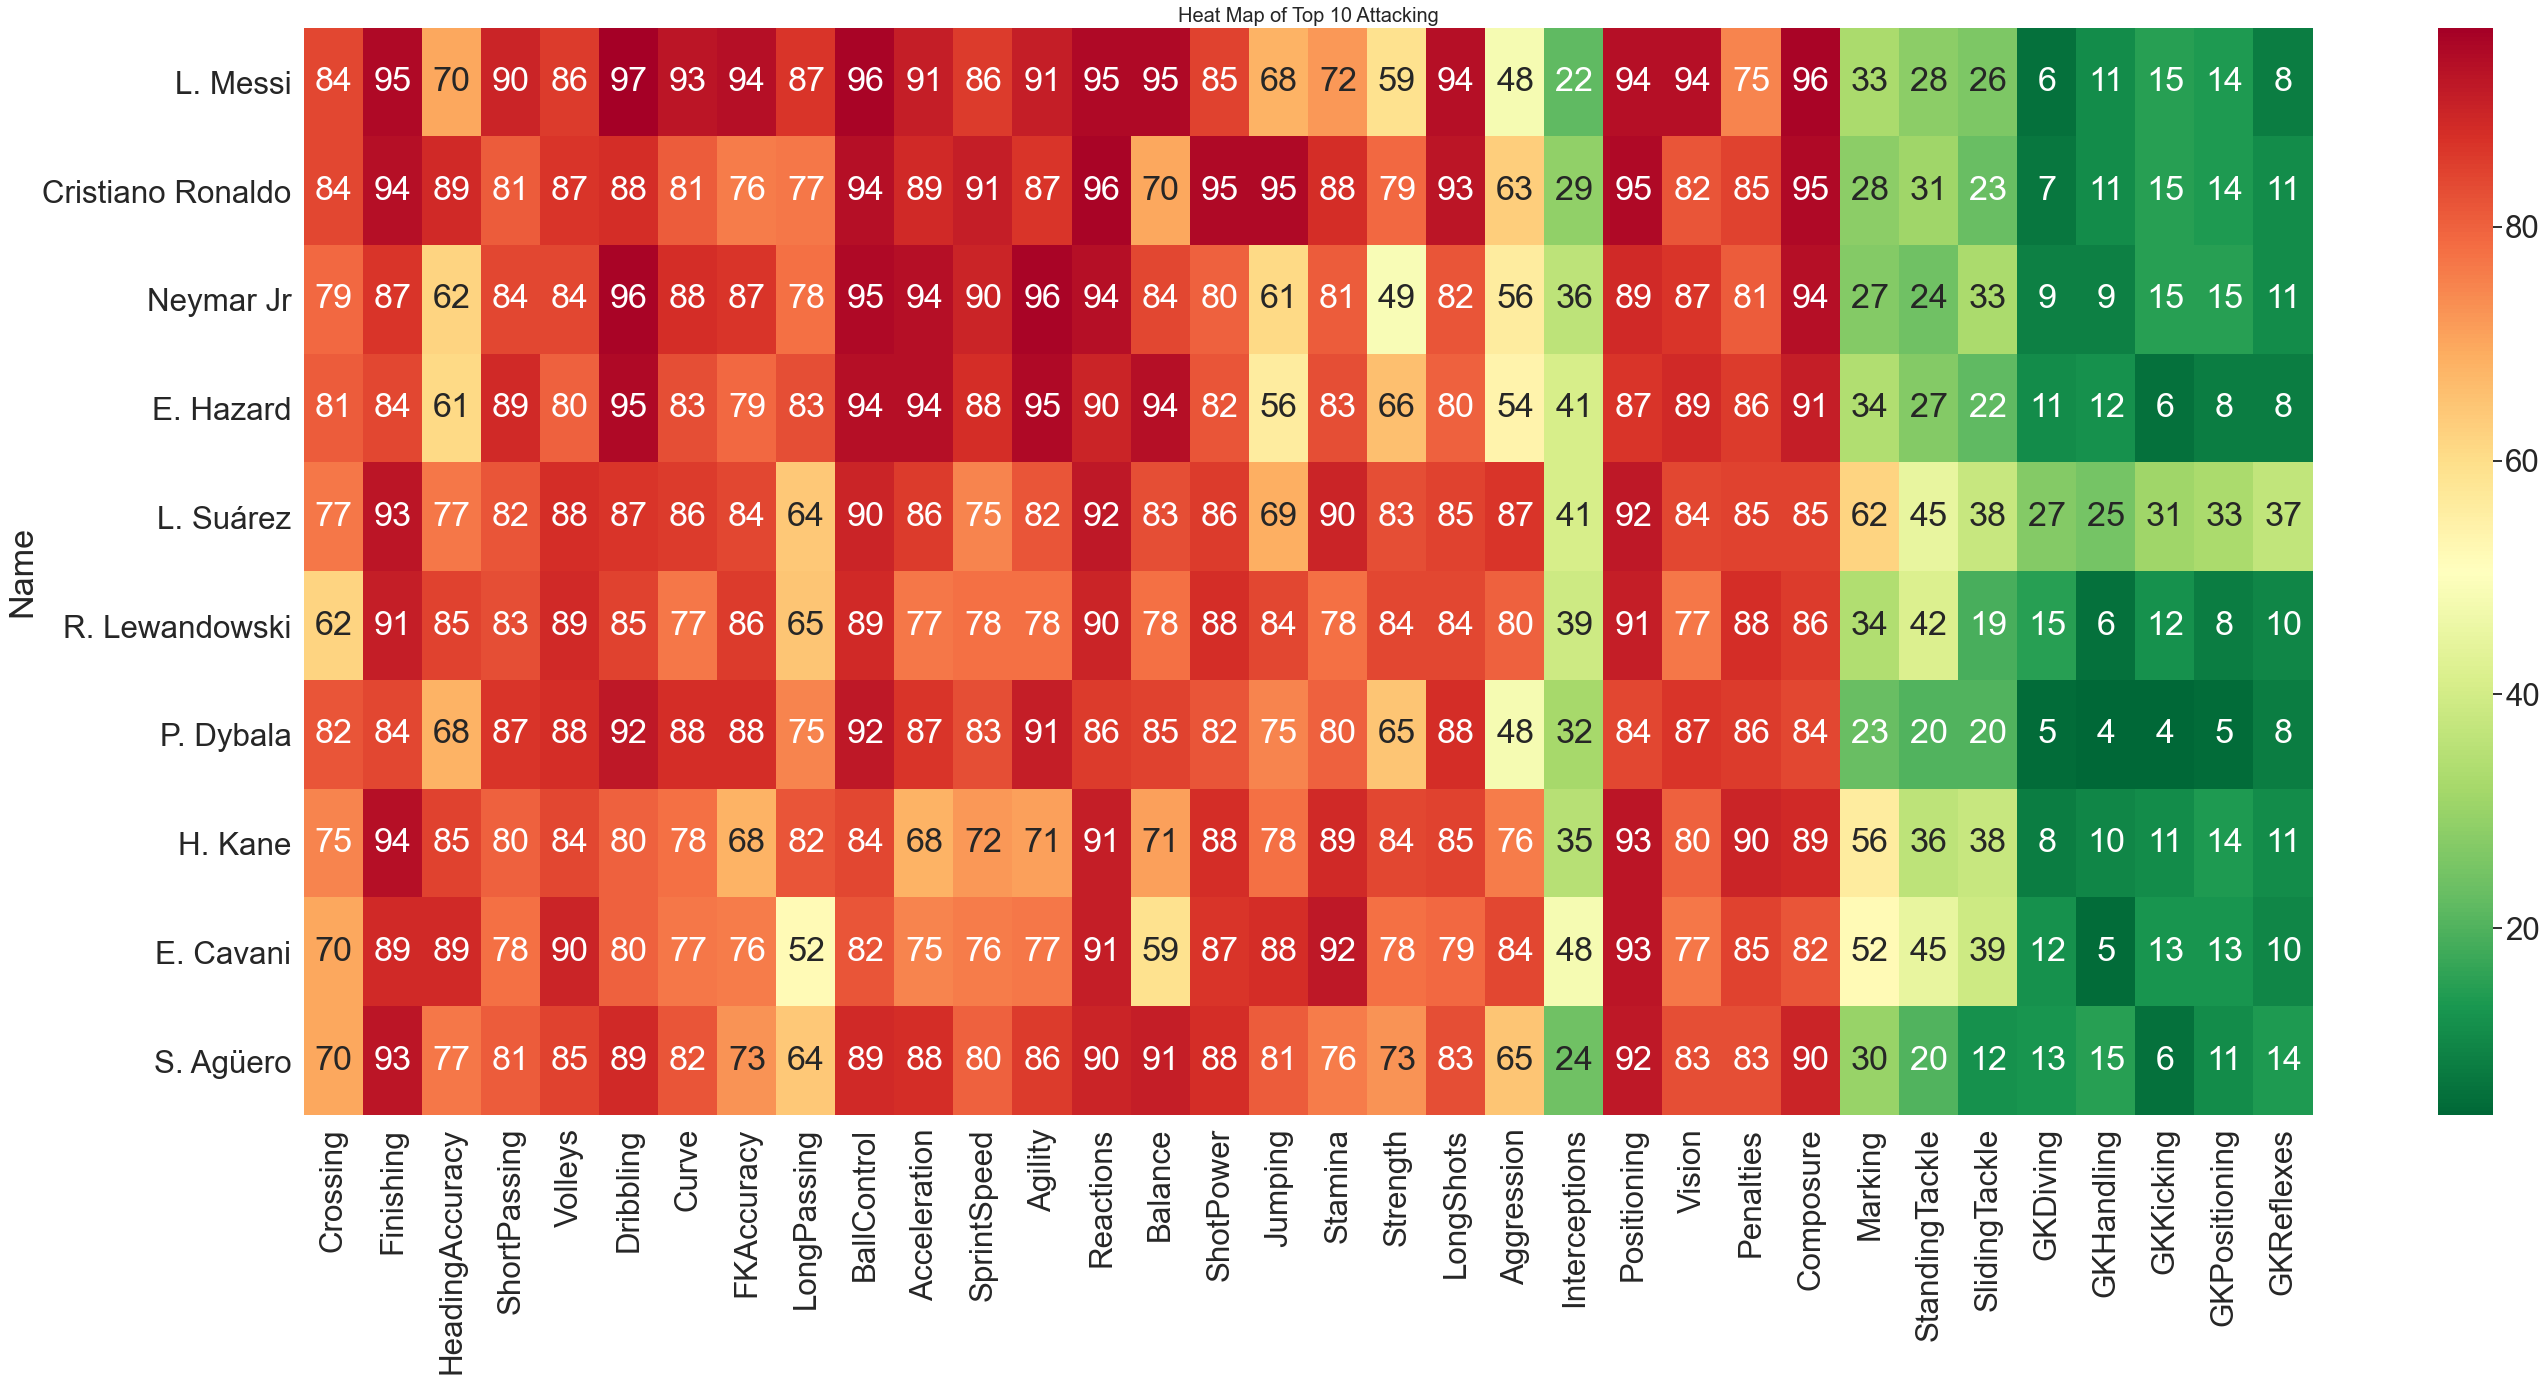

In [33]:
# Every attribute value for top attacking players
plt.figure(figsize=(45,20))
sns.heatmap(attributes.loc[attributes["Main Position"]=="Attacking"].drop("Main Position",axis=1)[:10],cmap="RdYlGn_r",annot=True)
plt.title("Heat Map of Top 10 Attacking",fontsize=20)
plt.show()

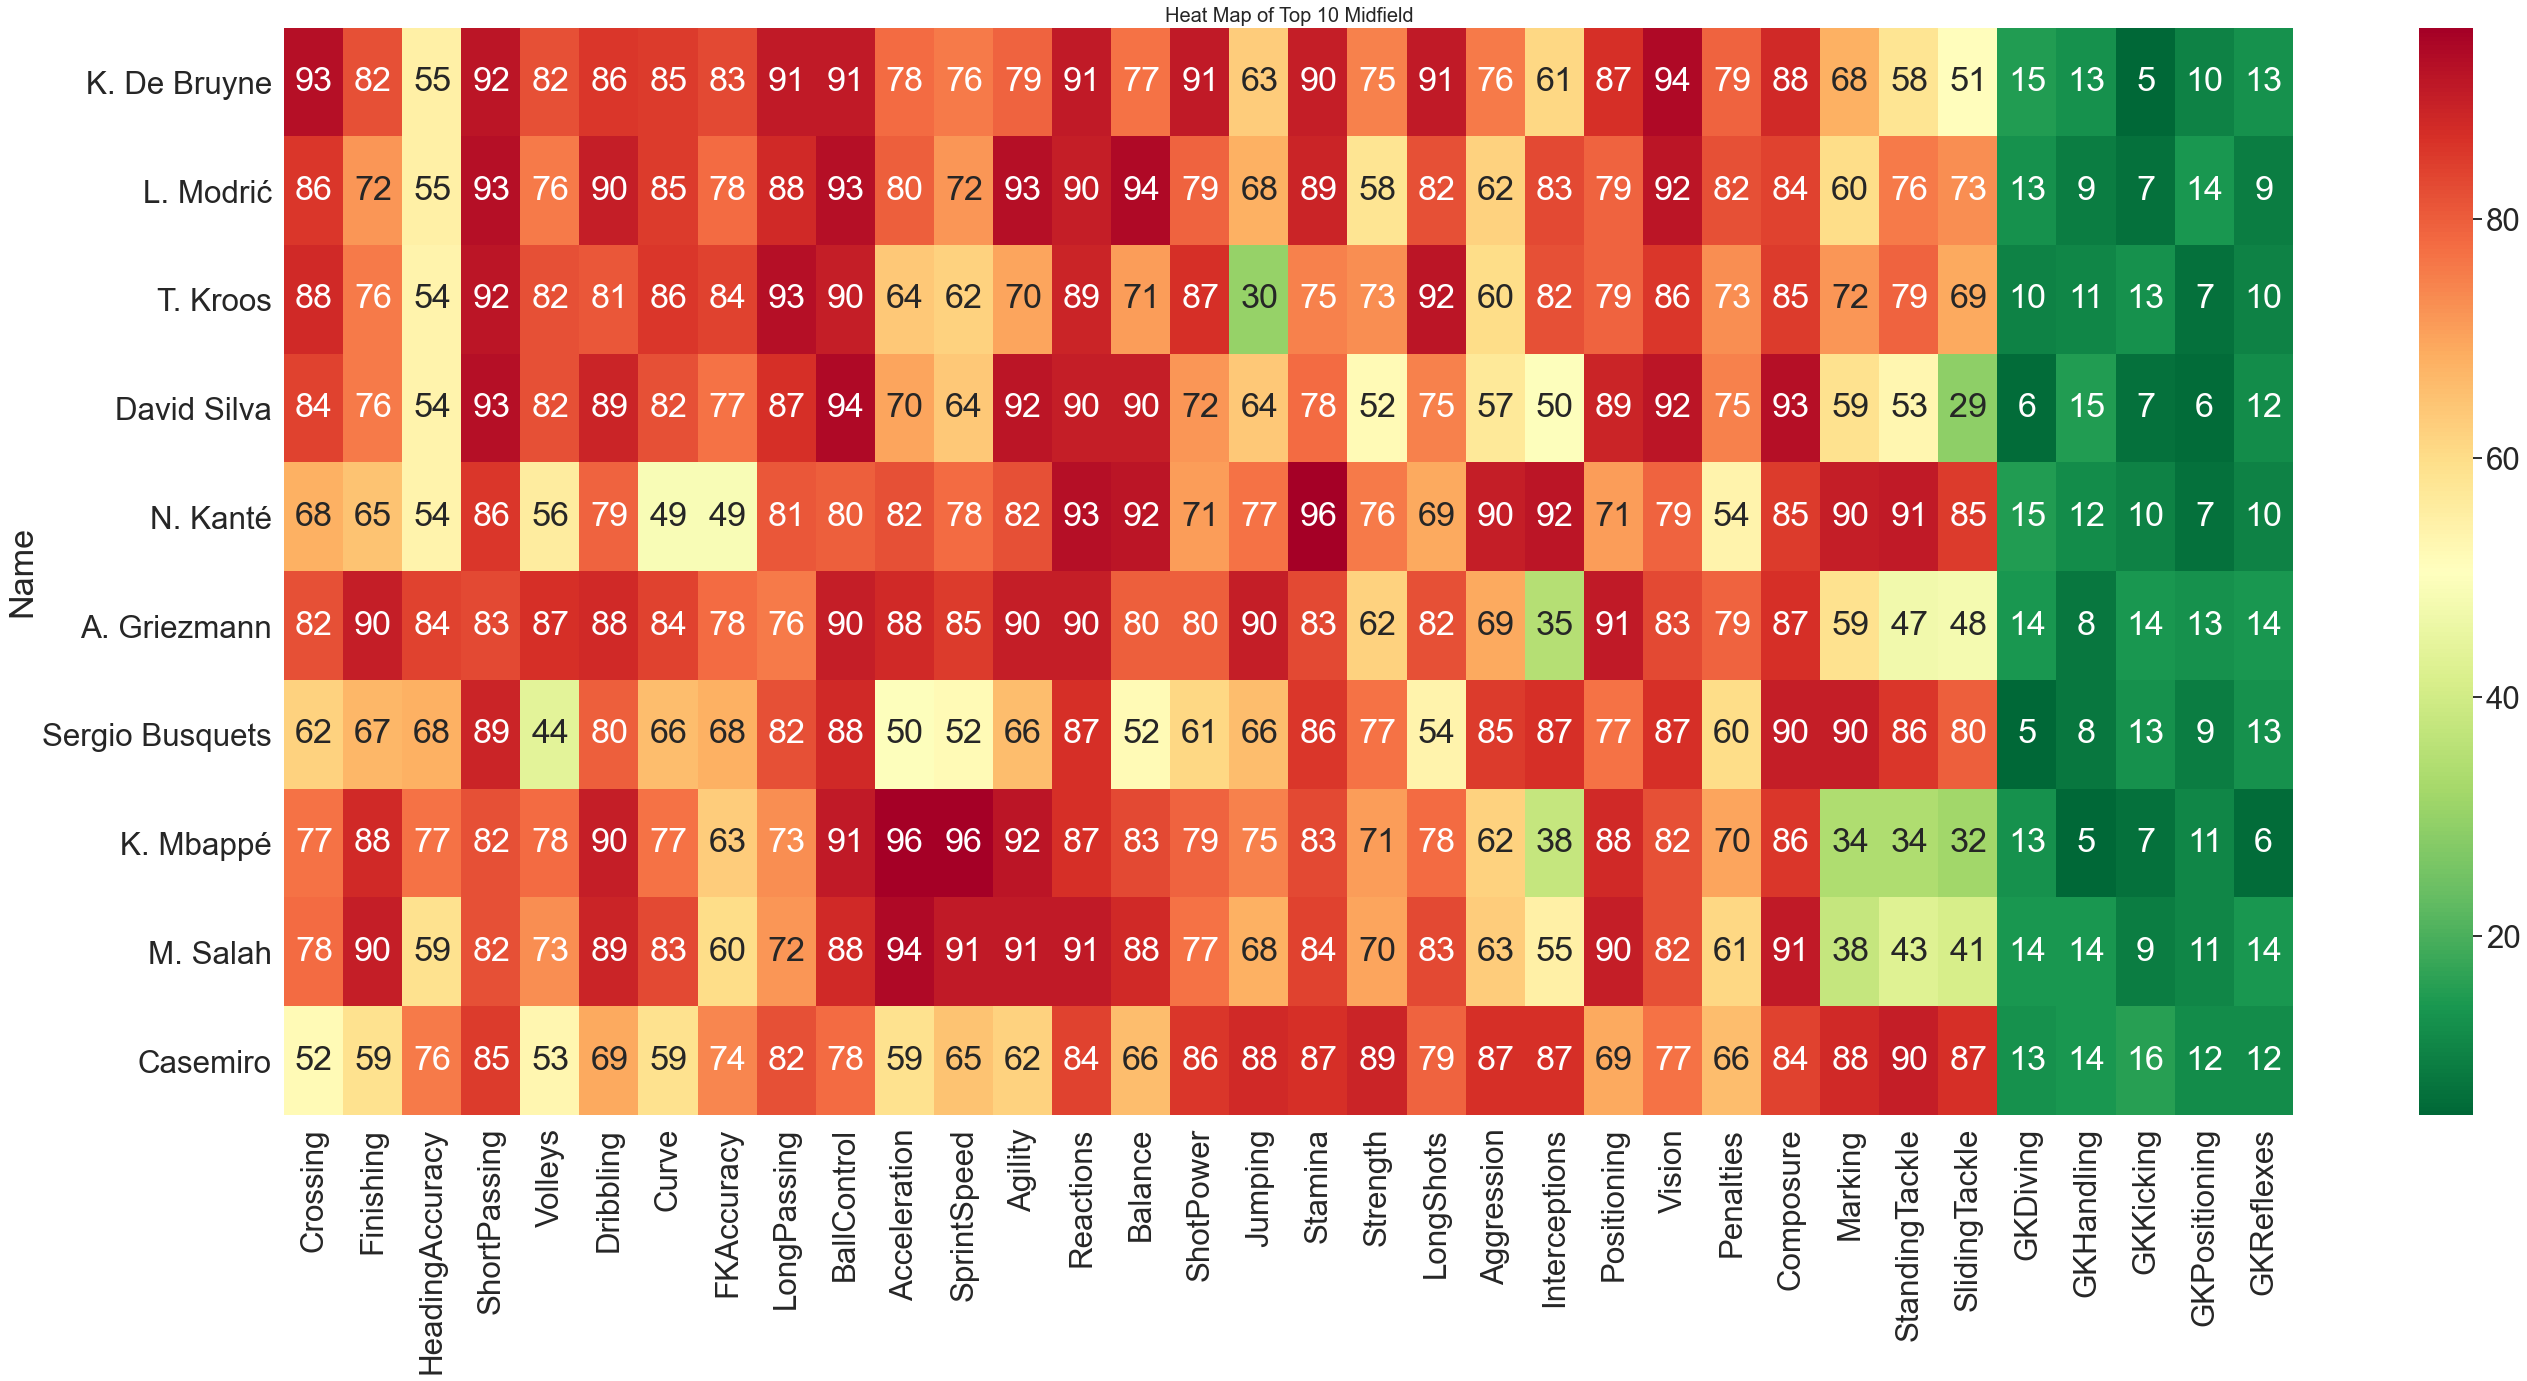

In [34]:
# Same for midfield players
plt.figure(figsize=(45,20))
sns.heatmap(attributes.loc[attributes["Main Position"]=="Midfield"].drop("Main Position",axis=1)[:10],cmap="RdYlGn_r",annot=True)
plt.title("Heat Map of Top 10 Midfield",fontsize=20)
plt.show()

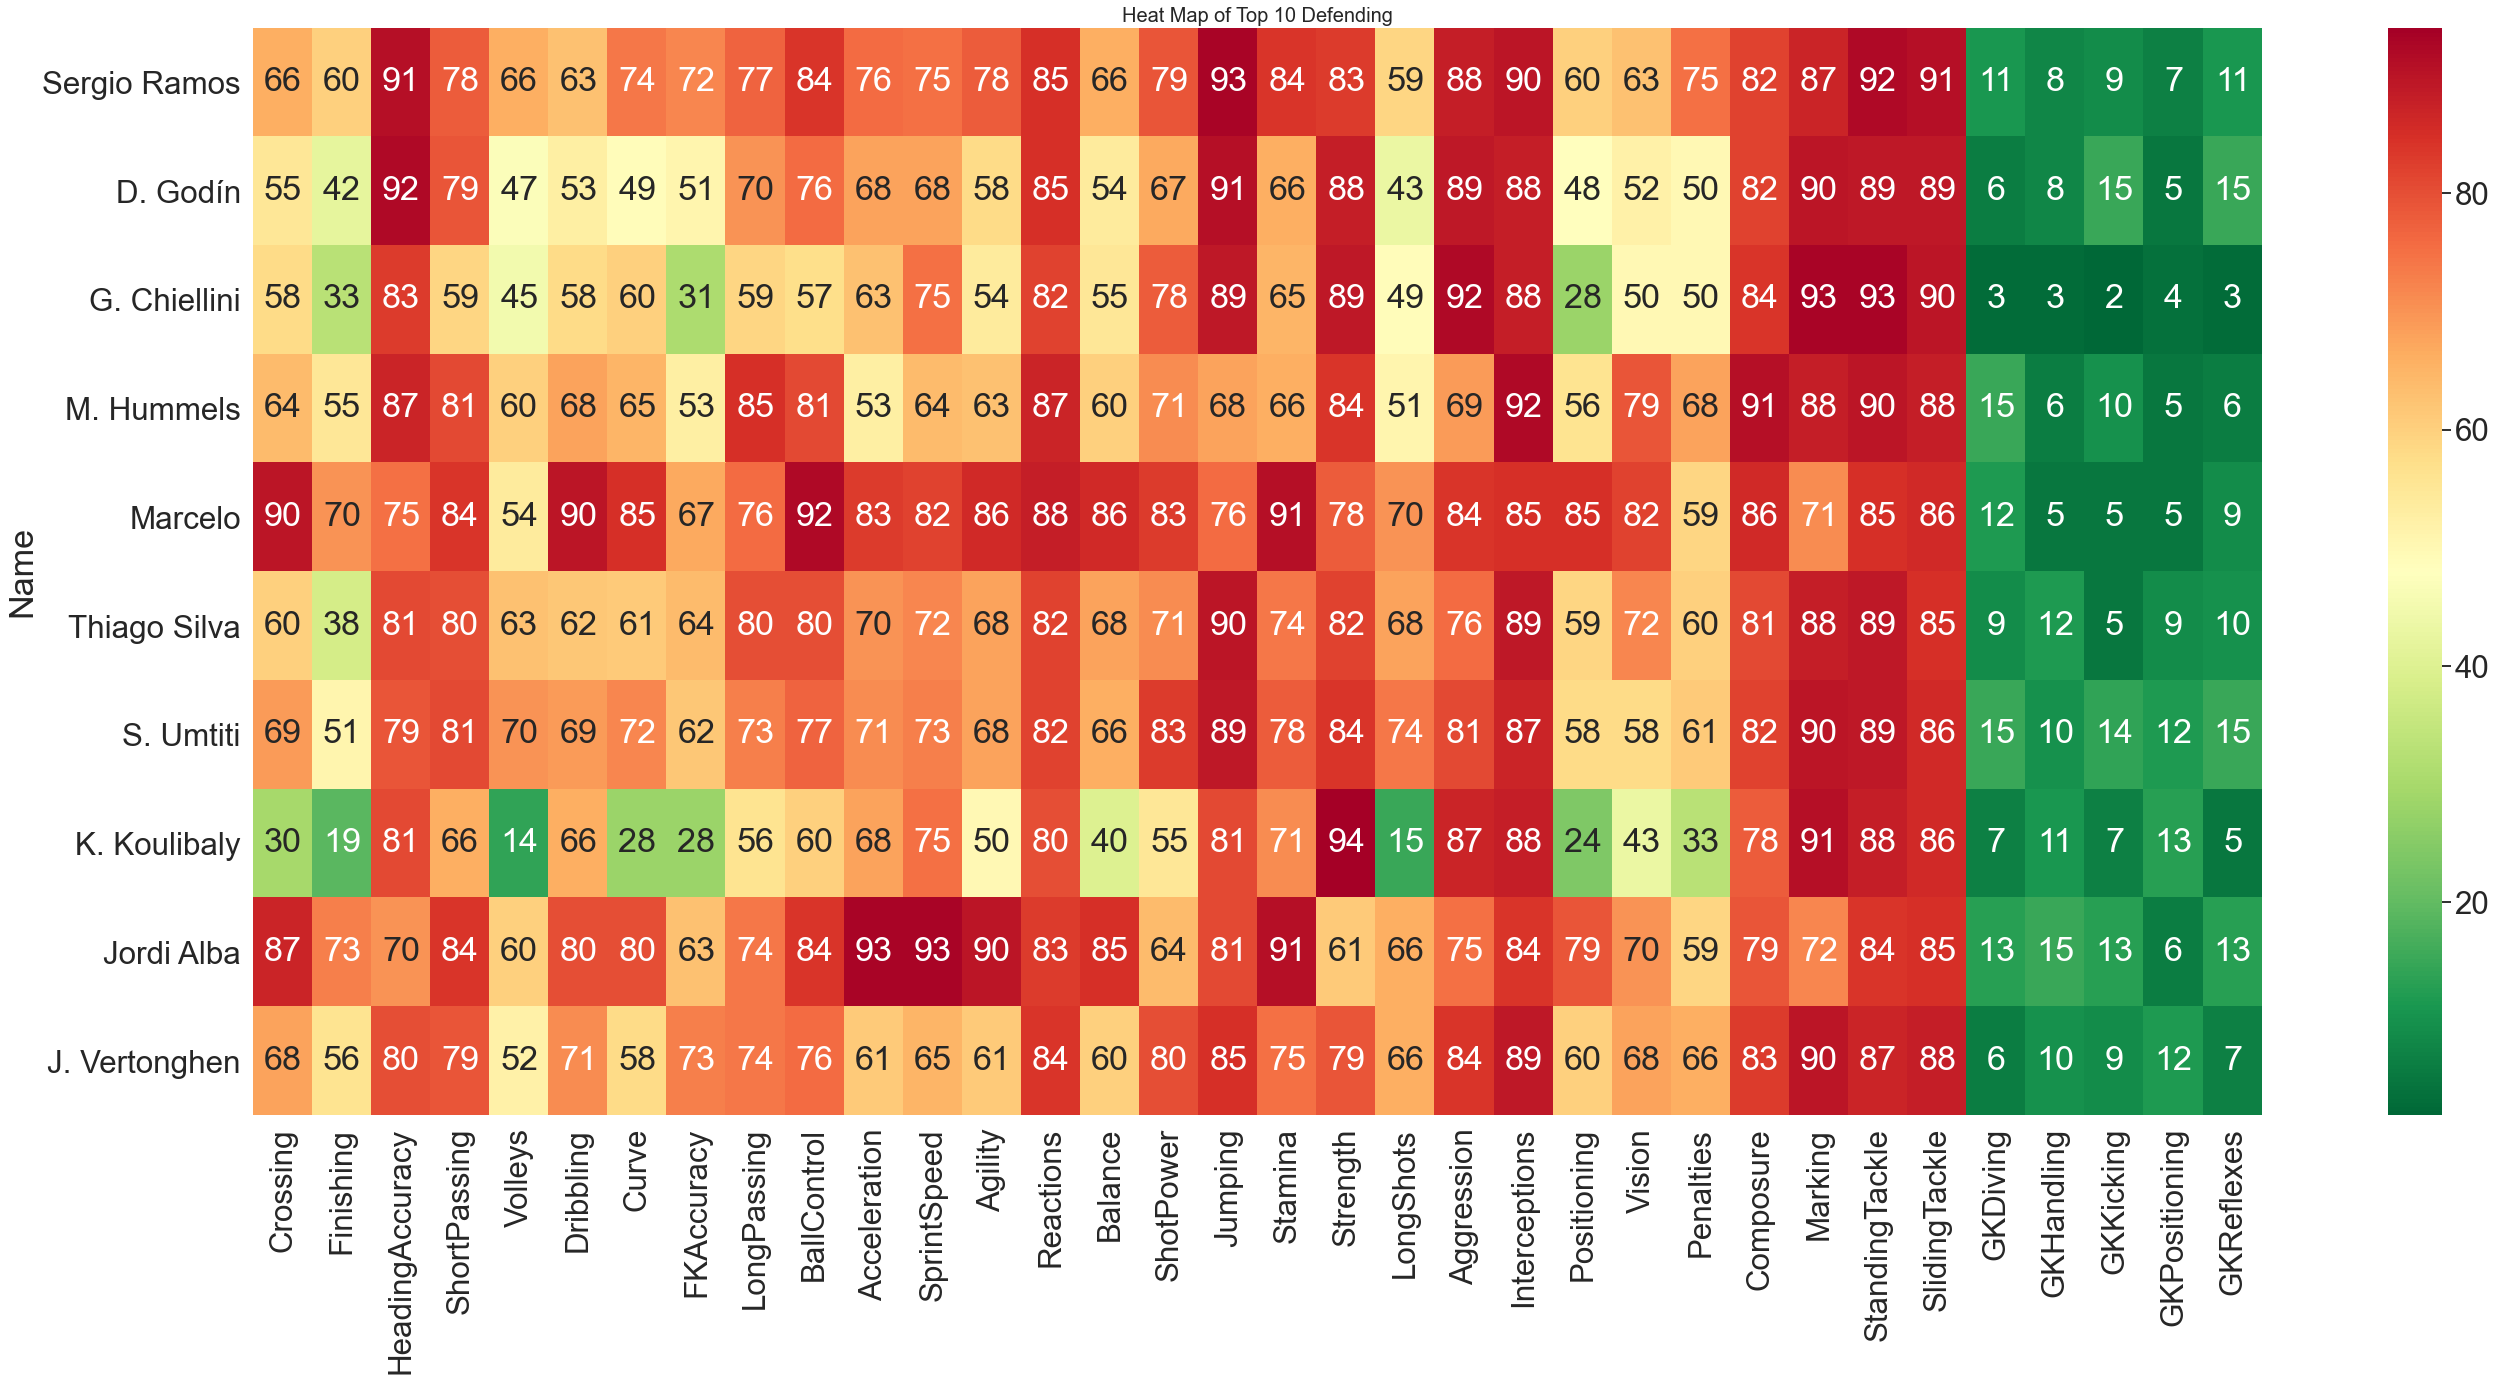

In [35]:
# Same for Defenders
plt.figure(figsize=(45,20))
sns.heatmap(attributes.loc[attributes["Main Position"]=="Defending"].drop("Main Position",axis=1)[:10],cmap="RdYlGn_r",annot=True)
plt.title("Heat Map of Top 10 Defending",fontsize=20)
plt.show()

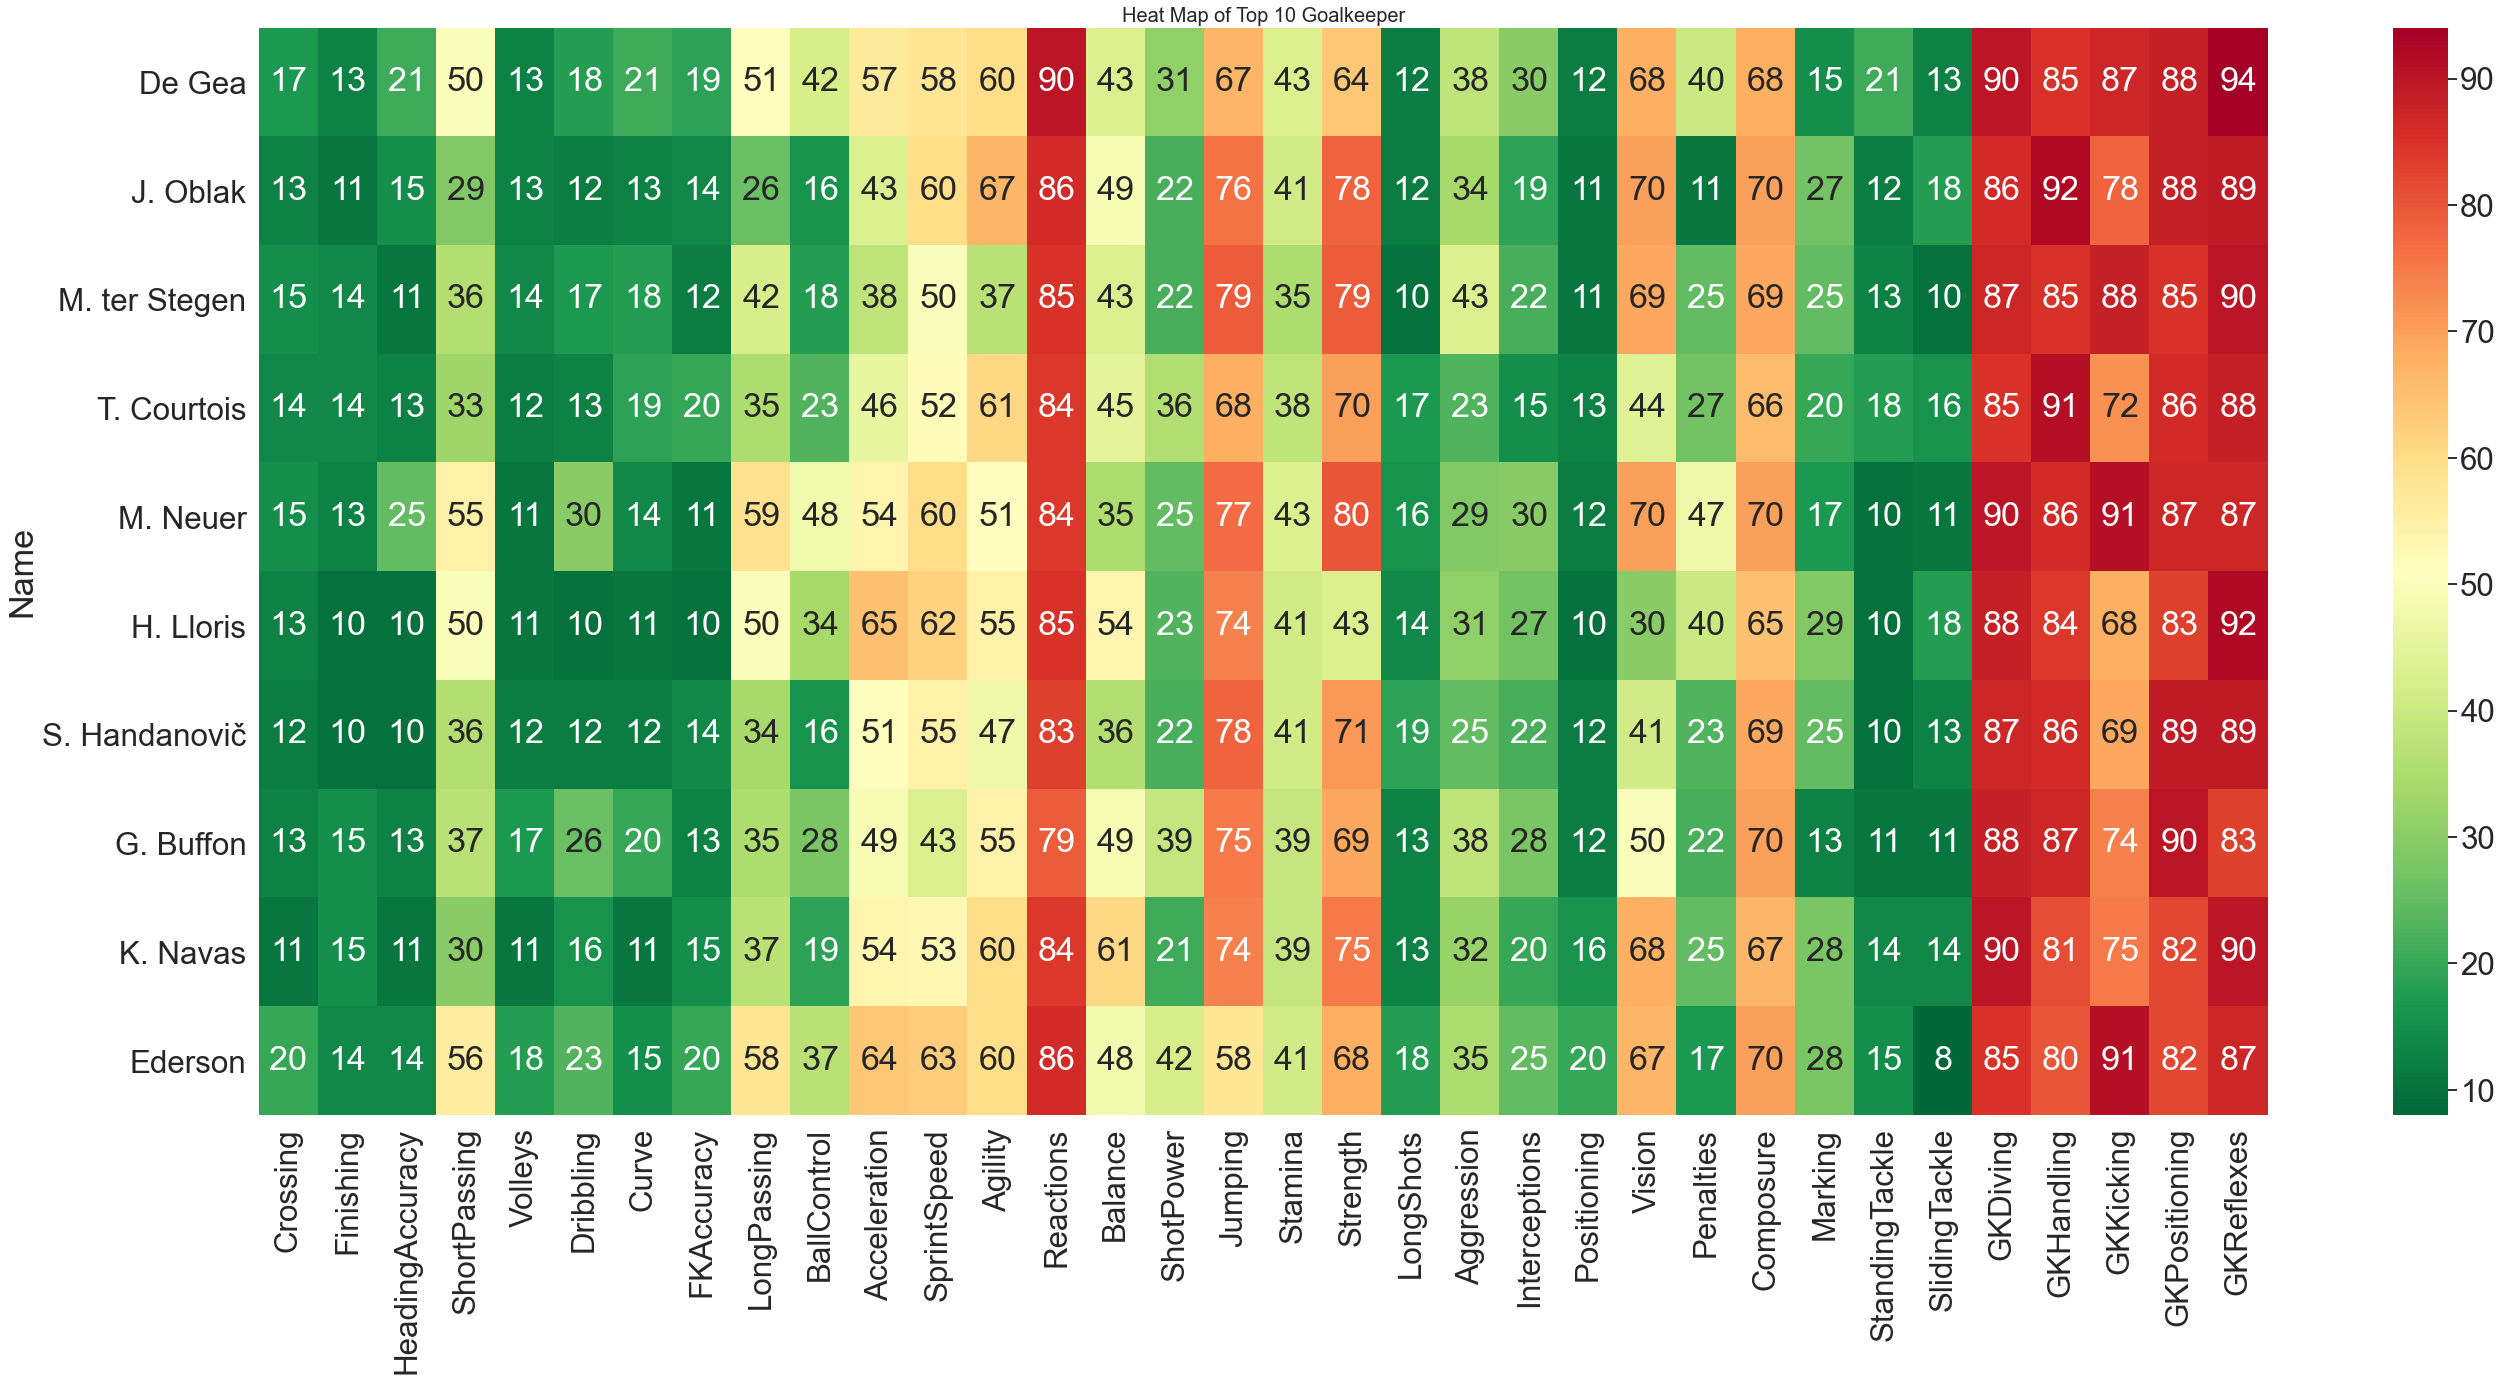

In [36]:
# Not forgetting the GoalKeepers
plt.figure(figsize=(45,20))
sns.heatmap(attributes.loc[attributes["Main Position"]=="Goalkeeper"].drop("Main Position",axis=1)[:10],cmap="RdYlGn_r",annot=True)
plt.title("Heat Map of Top 10 Goalkeeper",fontsize=20)
plt.show()

In [37]:
# Drop column
attributes.drop("Main Position",axis=1,inplace=True)

## III. CLUSTERING TO HELP MANAGERS

### K-MEANS CLUSTERING

Our main aim is to cluster similar players according to skillset of a player. The previously created attributes dataframe consisting pf only the skills of the player. This skills dataframe will be used to cluster players. 

The steps used are:

1. Scale the data - without scaling, some variables, especially 'Special' will skew the clusters.
2. Run K-Means by looping through a number of cluster centres(range from 1-10) to find the optimal number (k). This is done visually, where we see the elbow of the plot "bending".
3. Set the number of centres after step 2
4. Re-run the model with K value we found from the plot
5. Assign the cluster group back to the main data

In [38]:
from sklearn import preprocessing
x = attributes.values # numpy array
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)
X_norm = pd.DataFrame(x_scaled)

Considering the large number of attributes, performing PCA for dimension reduction would help us to reduce the number of attributes as input to the algorithm as well as reduce the run time of the algorithm. 

In [39]:
# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components = 2) # 2D PCA 
reduced = pd.DataFrame(pca.fit_transform(X_norm))

In [40]:
# Performing K- means 
from sklearn.cluster import KMeans
cluster_range = range( 1, 11 )
cluster_errors = []

for num_clusters in cluster_range:
  clusters = KMeans( num_clusters )
  clusters.fit( reduced )
  cluster_errors.append( clusters.inertia_ )

In [41]:
# The errors of esch cluster
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )
clusters_df

num_clusters  cluster_errors
0             1      293.987393
1             2       97.981775
2             3       30.523443
3             4       13.782805
4             5        9.676739
5             6        7.422007
6             7        5.871389
7             8        4.937517
8             9        4.366316
9            10        3.845438

Text(0, 0.5, 'Sum of squared errors')

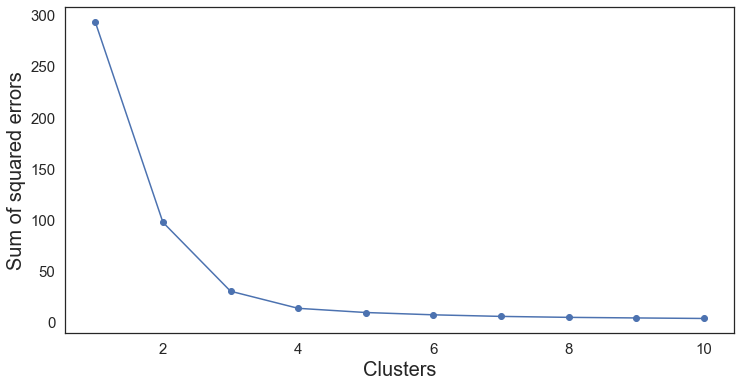

In [42]:
# Plotting graph to obtain the best number of cluster
sns.set(style="white")
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )
plt.tick_params(labelsize=15)

plt.xlabel("Clusters", fontsize=20)
plt.ylabel("Sum of squared errors", fontsize=20)

Plot suggests 4 or 5 clusters are the most feasible choices. We will use k=4 for our algorithm. 

In [43]:
from sklearn.cluster import KMeans
# specify the number of clusters
kmeans = KMeans(n_clusters=4)
# fit the input data
kmeans = kmeans.fit(reduced)
# get the cluster labels
labels = kmeans.predict(reduced)
# centroid values
centroid = kmeans.cluster_centers_
# cluster values
clusters = kmeans.labels_.tolist()

In [44]:
reduced['cluster'] = clusters
reduced['name'] = fifa['Name']
reduced.columns = ['x', 'y', 'cluster', 'name']
reduced=pd.DataFrame(reduced)
reduced.head()

x         y  cluster               name
0 -0.912703 -1.205159        2           L. Messi
1 -0.842903 -0.879848        2  Cristiano Ronaldo
2 -0.775225 -1.118180        2          Neymar Jr
3  2.769006 -0.482952        1             De Gea
4 -0.914584 -0.292244        2       K. De Bruyne

Here we see how each player is assigned to a cluster number. 

/Users/shalin/opt/anaconda3/lib/python3.8/site-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


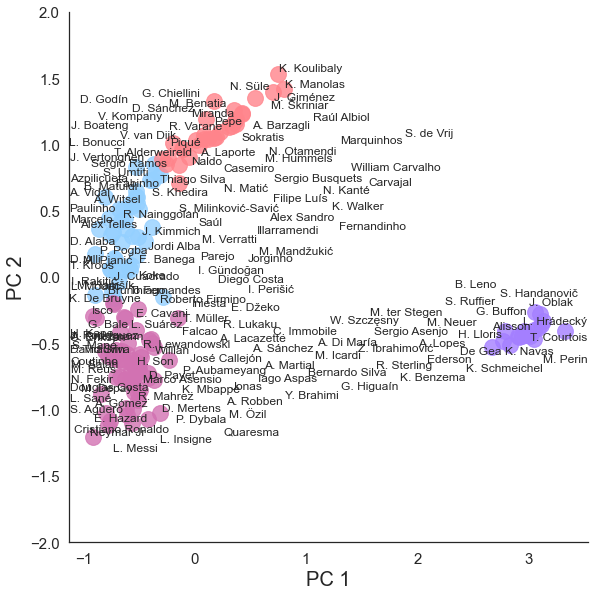

In [45]:
from adjustText import adjust_text
from vapeplot import vapeplot

sns.set(style="white")
pal =  sns.blend_palette(vapeplot.palette('vaporwave'))

ax = sns.lmplot(x="x", y="y",hue='cluster', data=reduced, legend=False,
                   fit_reg=False, size =8, scatter_kws={"s": 250}, palette=pal)

texts = []
for x, y, s in zip(reduced.x, reduced.y, reduced.name):
    texts.append(plt.text(x, y, s))
adjust_text(texts) #, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))  # uncomment to add arrows to labels

#ax._legend.set_title(prop={fontsize:'15'})
ax.set(ylim=(-2, 2))
plt.tick_params(labelsize=15)
#plt.setp(ax.get_legend().get_title(), fontsize='15')
plt.xlabel("PC 1", fontsize=20)
plt.ylabel("PC 2", fontsize=20)

plt.show()
# ax.savefig("newc_man_kmeans.jpg")

The plot looks messy, but we can clearly see 4 clusters plotted according to skillset. 

In [46]:
fifa = fifa.merge(reduced, how='outer', left_on='Name', right_on='name')

In [47]:
fifa.head()

Name  Age Nationality  Overall  Potential  \
0           L. Messi   31   Argentina       94         94   
1  Cristiano Ronaldo   33    Portugal       94         94   
2          Neymar Jr   26      Brazil       92         93   
3             De Gea   27       Spain       91         93   
4       K. De Bruyne   27     Belgium       91         92   

                  Club        Value      Wage Preferred Foot  \
0         FC Barcelona  110500000.0  565000.0           Left   
1             Juventus   77000000.0  405000.0          Right   
2  Paris Saint-Germain  118500000.0  290000.0          Right   
3    Manchester United   72000000.0  260000.0          Right   
4      Manchester City  102000000.0  355000.0          Right   

   International Reputation  ...  GKHandling  GKKicking GKPositioning  \
0                       5.0  ...        11.0       15.0          14.0   
1                       5.0  ...        11.0       15.0          14.0   
2                       5.0  ...         9.0       15.0          15.0   
3                       4.0  ...        85.0       87.0          88.0   
4                       4.0  ...        13.0        5.0          10.0   

  GKReflexes  Release Clause Main Position         x         y cluster  \
0        8.0     226500000.0     Attacking -0.912703 -1.205159       2   
1       11.0     127100000.0     Attacking -0.842903 -0.879848       2   
2       11.0     228100000.0     Attacking -0.775225 -1.118180       2   
3       94.0     138600000.0    Goalkeeper  2.769006 -0.482952       1   
4       13.0     196400000.0      Midfield -0.914584 -0.292244       2   

                name  
0           L. Messi  
1  Cristiano Ronaldo  
2          Neymar Jr  
3             De Gea  
4       K. De Bruyne  

[5 rows x 81 columns]

In [48]:
fifa.drop(columns=['x','y','name'],inplace=True)

In [49]:
fifa.shape

(155, 78)

In [50]:
pd.DataFrame(fifa.groupby('cluster')["Main Position"].value_counts())

Main Position
cluster Main Position               
0       Midfield                  32
        Defending                 10
        Attacking                  2
1       Goalkeeper                19
2       Attacking                 37
        Midfield                  24
3       Defending                 29
        Midfield                   2

Cluster 0 appears to groiup the more defensive-midfielder types (made up mainly of DEFs and MIDs). 
Cluster 1 appears to group all the goalkeepers. 
Cluster 2 looks to be grouping the defenders minded midfielders.
Cluster 3 looks to be grouping very attacking minded midfielders midfielders (mande up mainly of MIDs and FWDs).







In [51]:
# Show each cluster with it's values
top10_gk = fifa[fifa['Main Position'] == 'Goalkeeper'].nlargest(10, 'Overall')
top10_df = fifa[fifa['Main Position'] == 'Defending'].nlargest(10, 'Overall')
top10_mf = fifa[fifa['Main Position'] == 'Midfield'].nlargest(10, 'Overall')
top10_st = fifa[fifa['Main Position'] == 'Attacking'].nlargest(10, 'Overall')
top10_players = top10_gk.append([top10_df, top10_mf, top10_st])
top10_players = top10_players.sort_values(by=['Main Position', 'Overall'])
top10_players

Name  Age Nationality  Overall  Potential  \
15          P. Dybala   24   Argentina       89         94   
16            H. Kane   24     England       89         91   
21          E. Cavani   31     Uruguay       89         89   
23          S. Agüero   30   Argentina       89         89   
10     R. Lewandowski   29      Poland       90         90   
5           E. Hazard   27     Belgium       91         91   
7           L. Suárez   31     Uruguay       91         91   
2           Neymar Jr   26      Brazil       92         93   
0            L. Messi   31   Argentina       94         94   
1   Cristiano Ronaldo   33    Portugal       94         94   
42          S. Umtiti   24      France       87         92   
44       K. Koulibaly   27     Senegal       87         90   
49         Jordi Alba   29       Spain       87         87   
51      J. Vertonghen   31     Belgium       87         87   
34         M. Hummels   29     Germany       88         88   
35            Marcelo   30      Brazil       88         88   
39       Thiago Silva   33      Brazil       88         88   
24       G. Chiellini   33       Italy       89         89   
12           D. Godín   32     Uruguay       90         90   
8        Sergio Ramos   32       Spain       91         91   
57            Ederson   24      Brazil       86         90   
46           K. Navas   31  Costa Rica       87         87   
37          H. Lloris   31      France       88         88   
40      S. Handanovič   33    Slovenia       88         88   
41          G. Buffon   40       Italy       88         88   
18      M. ter Stegen   26     Germany       89         92   
19        T. Courtois   26     Belgium       89         90   
22           M. Neuer   32     Germany       89         89   
9            J. Oblak   25    Slovenia       90         93   
3              De Gea   27       Spain       91         93   
25          K. Mbappé   19      France       88         95   
26           M. Salah   26       Egypt       88         89   
27           Casemiro   26      Brazil       88         90   
14           N. Kanté   27      France       89         90   
17       A. Griezmann   27      France       89         90   
20    Sergio Busquets   29       Spain       89         89   
11           T. Kroos   28     Germany       90         90   
13        David Silva   32       Spain       90         90   
4        K. De Bruyne   27     Belgium       91         92   
6           L. Modrić   32     Croatia       91         91   

                   Club        Value      Wage Preferred Foot  \
15             Juventus   89000000.0  205000.0           Left   
16    Tottenham Hotspur   83500000.0  205000.0          Right   
21  Paris Saint-Germain   60000000.0  200000.0          Right   
23      Manchester City   64500000.0  300000.0          Right   
10    FC Bayern München   77000000.0  205000.0          Right   
5               Chelsea   93000000.0  340000.0          Right   
7          FC Barcelona   80000000.0  455000.0          Right   
2   Paris Saint-Germain  118500000.0  290000.0          Right   
0          FC Barcelona  110500000.0  565000.0           Left   
1              Juventus   77000000.0  405000.0          Right   
42         FC Barcelona   57000000.0  205000.0           Left   
44               Napoli   51000000.0  115000.0          Right   
49         FC Barcelona   38000000.0  250000.0           Left   
51    Tottenham Hotspur   34000000.0  155000.0           Left   
34    FC Bayern München   46000000.0  160000.0          Right   
35          Real Madrid   43000000.0  285000.0           Left   
39  Paris Saint-Germain   24000000.0  165000.0          Right   
24             Juventus   27000000.0  215000.0           Left   
12      Atlético Madrid   44000000.0  125000.0          Right   
8           Real Madrid   51000000.0  380000.0          Right   
57      Manchester City   41500000.0  125000.0           Left   
46          Real Madrid   30500000.0  195000

In [52]:
# Attacking players cluster
import plotly.express as px

n = top10_players['Name'][0:10]
v = top10_players['Overall'][0:10]
d = top10_players['Value'][0:10]

fig = px.scatter(top10_players, x=d, y=v,text=n,
                labels={
                     "x": "Value(in millions)",
                     "y": "Overall Rating"
                     
                 },
                title="Clustering for Top Attacking Players")

fig.show()

In [53]:
# Top Defenders Cluster
n = top10_players['Name'][11:20]
v = top10_players['Overall'][11:20]
d = top10_players['Value'][11:20]

fig = px.scatter(top10_players, x=d, y=v,text=n,
                labels={
                     "x": "Value(in millions)",
                     "y": "Overall Rating"
                     
                 },
                title="Clustering for Top Defending Players")

fig.show()

In [54]:
# Top Goalkeepers cluster
n = top10_players['Name'][21:30]
v = top10_players['Overall'][21:30]
d = top10_players['Value'][21:30]

fig = px.scatter(top10_players, x=d, y=v,text=n,
                labels={
                     "x": "Value(in millions)",
                     "y": "Overall Rating"
                     
                 },
                title="Clustering for Top GoalKeeping Players")

fig.show()

In [55]:
# Top Midfield cluster
n = top10_players['Name'][31:40]
v = top10_players['Overall'][31:40]
d = top10_players['Value'][31:40]

fig = px.scatter(top10_players, x=d, y=v,text=n,
                labels={
                     "x": "Value(in millions)",
                     "y": "Overall Rating"
                     
                 },
                title="Clustering for Top Midfield Players")

fig.show()

Plotting the 10 highest rated players in each cluster shows us which players are similar in terms of their skill sets.
The above plots helps a soccer manager to group similar players and consider players according to the overall rating and market value. This can help a manager to consider players according to the club budget. 

In [56]:
reduced.drop("cluster",axis=1,inplace=True)
reduced.drop("name",axis=1,inplace=True)

### DBSCAN

In [57]:
from sklearn.cluster import DBSCAN

# train the model using DBSCAN
db = DBSCAN(eps=1, min_samples=4)

# prediction for dbscan clusters
db_clusters = db.fit_predict(reduced)

In [58]:
names = fifa.Name.tolist() # saving names for later

reduced['cluster'] = db_clusters
reduced['name'] = names
reduced.columns = ['x', 'y', 'cluster', 'name']
reduced.head()

x         y  cluster               name
0 -0.912703 -1.205159        0           L. Messi
1 -0.842903 -0.879848        0  Cristiano Ronaldo
2 -0.775225 -1.118180        0          Neymar Jr
3  2.769006 -0.482952        1             De Gea
4 -0.914584 -0.292244        0       K. De Bruyne

/Users/shalin/opt/anaconda3/lib/python3.8/site-packages/seaborn/regression.py:580: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



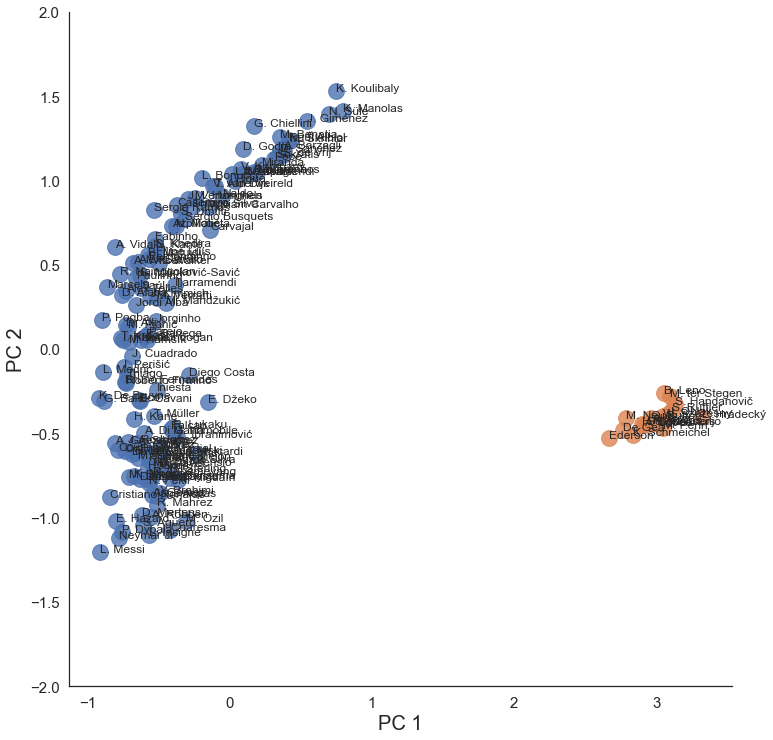

In [59]:
sns.set(style="white")

ax = sns.lmplot(x="x", y="y", hue='cluster', data = reduced, legend=False,
                   fit_reg=False, size = 10, scatter_kws={"s": 250})

texts = []
for x, y, s in zip(reduced.x, reduced.y, reduced.name):
    texts.append(plt.text(x, y, s))

ax.set(ylim=(-2, 2))
plt.tick_params(labelsize=15)
plt.xlabel("PC 1", fontsize = 20)
plt.ylabel("PC 2", fontsize = 20)

plt.show()

11 Clusters are created here. 

In [60]:
reduced.drop("cluster",axis=1,inplace=True)
reduced.drop("name",axis=1,inplace=True)

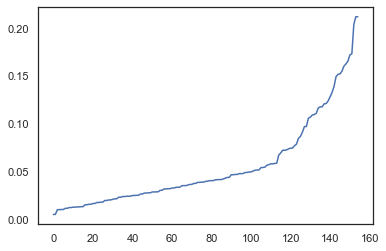

In [61]:
from sklearn.neighbors import NearestNeighbors

# calculate the distance from each point to its closest neighbor
nn = NearestNeighbors(n_neighbors = 2)

# fit the nearest neighbor
nbrs = nn.fit(reduced)

# returns two arrays - distance to the closest n_neighbors points and index for each point
distances, indices = nbrs.kneighbors(reduced)

# sort the distance and plot it
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

Plottinng for obtaing the epsilon value for DB Scan.

In [62]:
# train the model using DBSCAN with best epsilon
db= DBSCAN(eps=0.07, min_samples=4)

# prediction for dbscan clusters
db_clusters = db.fit_predict(reduced)

reduced['cluster'] = db_clusters
reduced['name'] = names
reduced.columns = ['x', 'y', 'cluster', 'name']
reduced.head()

x         y  cluster               name
0 -0.912703 -1.205159       -1           L. Messi
1 -0.842903 -0.879848       -1  Cristiano Ronaldo
2 -0.775225 -1.118180       -1          Neymar Jr
3  2.769006 -0.482952       -1             De Gea
4 -0.914584 -0.292244       -1       K. De Bruyne

/Users/shalin/opt/anaconda3/lib/python3.8/site-packages/seaborn/regression.py:580: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



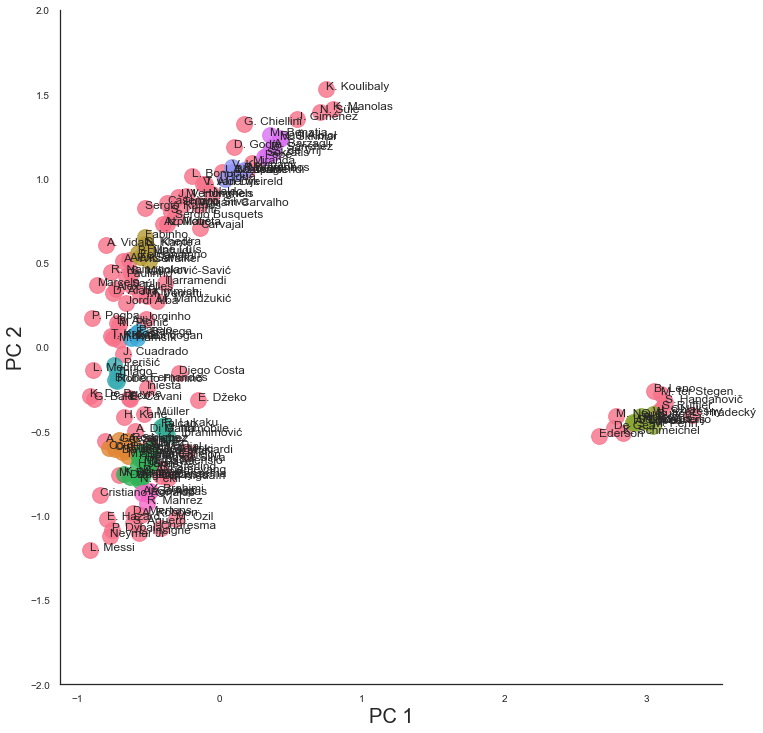

In [63]:
sns.set(style="white")

ax = sns.lmplot(x="x", y="y", hue='cluster', data = reduced, legend=False,
                   fit_reg=False, size = 10, scatter_kws={"s": 250})

texts = []
for x, y, s in zip(reduced.x, reduced.y, reduced.name):
    texts.append(plt.text(x, y, s))

ax.set(ylim=(-2, 2))
plt.tick_params(labelsize=10)
plt.xlabel("PC 1", fontsize = 20)
plt.ylabel("PC 2", fontsize = 20)

plt.show()

In [64]:
fifa.drop("cluster",axis=1,inplace=True)
fifa.head()

Name  Age Nationality  Overall  Potential  \
0           L. Messi   31   Argentina       94         94   
1  Cristiano Ronaldo   33    Portugal       94         94   
2          Neymar Jr   26      Brazil       92         93   
3             De Gea   27       Spain       91         93   
4       K. De Bruyne   27     Belgium       91         92   

                  Club        Value      Wage Preferred Foot  \
0         FC Barcelona  110500000.0  565000.0           Left   
1             Juventus   77000000.0  405000.0          Right   
2  Paris Saint-Germain  118500000.0  290000.0          Right   
3    Manchester United   72000000.0  260000.0          Right   
4      Manchester City  102000000.0  355000.0          Right   

   International Reputation  ...  Marking  StandingTackle SlidingTackle  \
0                       5.0  ...     33.0            28.0          26.0   
1                       5.0  ...     28.0            31.0          23.0   
2                       5.0  ...     27.0            24.0          33.0   
3                       4.0  ...     15.0            21.0          13.0   
4                       4.0  ...     68.0            58.0          51.0   

  GKDiving  GKHandling GKKicking GKPositioning GKReflexes Release Clause  \
0      6.0        11.0      15.0          14.0        8.0    226500000.0   
1      7.0        11.0      15.0          14.0       11.0    127100000.0   
2      9.0         9.0      15.0          15.0       11.0    228100000.0   
3     90.0        85.0      87.0          88.0       94.0    138600000.0   
4     15.0        13.0       5.0          10.0       13.0    196400000.0   

  Main Position  
0     Attacking  
1     Attacking  
2     Attacking  
3    Goalkeeper  
4      Midfield  

[5 rows x 77 columns]

In [65]:
fifa = fifa.merge(reduced, how='outer', left_on='Name', right_on='name')

In [66]:
fifa.drop(columns=['x','y','name'],inplace=True)
fifa.head()

Name  Age Nationality  Overall  Potential  \
0           L. Messi   31   Argentina       94         94   
1  Cristiano Ronaldo   33    Portugal       94         94   
2          Neymar Jr   26      Brazil       92         93   
3             De Gea   27       Spain       91         93   
4       K. De Bruyne   27     Belgium       91         92   

                  Club        Value      Wage Preferred Foot  \
0         FC Barcelona  110500000.0  565000.0           Left   
1             Juventus   77000000.0  405000.0          Right   
2  Paris Saint-Germain  118500000.0  290000.0          Right   
3    Manchester United   72000000.0  260000.0          Right   
4      Manchester City  102000000.0  355000.0          Right   

   International Reputation  ...  StandingTackle  SlidingTackle GKDiving  \
0                       5.0  ...            28.0           26.0      6.0   
1                       5.0  ...            31.0           23.0      7.0   
2                       5.0  ...            24.0           33.0      9.0   
3                       4.0  ...            21.0           13.0     90.0   
4                       4.0  ...            58.0           51.0     15.0   

  GKHandling  GKKicking GKPositioning GKReflexes Release Clause Main Position  \
0       11.0       15.0          14.0        8.0    226500000.0     Attacking   
1       11.0       15.0          14.0       11.0    127100000.0     Attacking   
2        9.0       15.0          15.0       11.0    228100000.0     Attacking   
3       85.0       87.0          88.0       94.0    138600000.0    Goalkeeper   
4       13.0        5.0          10.0       13.0    196400000.0      Midfield   

  cluster  
0      -1  
1      -1  
2      -1  
3      -1  
4      -1  

[5 rows x 78 columns]

In [67]:
pd.DataFrame(fifa.groupby('cluster')["Main Position"].value_counts())

Main Position
cluster Main Position               
-1      Midfield                  31
        Defending                 24
        Attacking                 21
        Goalkeeper                10
 0      Attacking                  4
        Midfield                   4
 1      Midfield                   5
        Defending                  2
 2      Goalkeeper                 9
 3      Midfield                   9
        Attacking                  7
 4      Attacking                  4
 5      Midfield                   4
 6      Midfield                   4
 7      Defending                  5
 8      Defending                  8
 9      Attacking                  3
        Midfield                   1

Probably, we are getting large number of clusters due to less datapoints used here for run time purposes. 

In [68]:
reduced.drop("cluster",axis=1,inplace=True)
reduced.drop("name",axis=1,inplace=True)
reduced.head()

x         y
0 -0.912703 -1.205159
1 -0.842903 -0.879848
2 -0.775225 -1.118180
3  2.769006 -0.482952
4 -0.914584 -0.292244

### Hierarchical Clustering

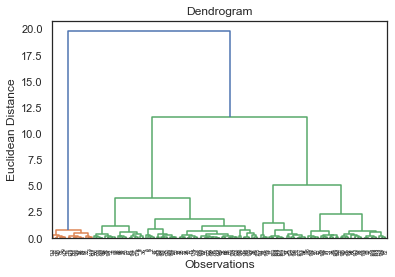

In [69]:
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(reduced, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Observations')
plt.ylabel('Euclidean Distance')
plt.show()

Using 4 clusters as seen from the figure. 

In [70]:
from sklearn.cluster import AgglomerativeClustering

AC = AgglomerativeClustering(n_clusters = 4)
AC.fit(reduced)

AgglomerativeClustering(n_clusters=4)

In [71]:
from scipy.cluster.vq import whiten

reduced['x_scaled'] = whiten(reduced['x'])
reduced['y_scaled'] = whiten(reduced['y'])

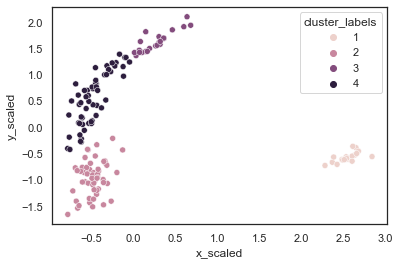

In [72]:
from scipy.cluster.hierarchy import linkage, fcluster

# Use the linkage()
distance_matrix = linkage(reduced[['x_scaled', 'y_scaled']], method='ward', metric='euclidean')

# Assign cluster labels
reduced['cluster_labels'] = fcluster(distance_matrix, 4, criterion='maxclust')

# Plot clusters
sns.scatterplot(x='x_scaled', y='y_scaled', hue='cluster_labels', data=reduced);

We can club Regression and Classification Algorithm after clustering. For example, for future work, we can predict the wages or potential of a player with respect to the skillset. We can use different clustering techniques matched with different regression algorithms according to the precision and errors generated from it. 